In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set(font_scale=1.2)

path = "../data/raw/final_data_mondinoxicot.xlsx"
df = pd.read_excel(path)

df.shape, df.head()

((274, 46),
   ID     Surname            Name Center Evaluation Date  HR V  HR ML  HR AP  \
 0  1   Addonisio  Franco Antonio   ICOT    22/ 22/2 223  1.64   1.55   1.48   
 1  2      Amadio           Luigi   ICOT    23/ 23/2 222  2.53   1.16   2.13   
 2  2      Amadio           Luigi   ICOT    13/ 27/2 222  2.14   1.33   1.22   
 3  3  Andryukhin       Volodymyr   ICOT    18/ 21/2 223  1.57   1.15   1.29   
 4  3  Andryukhin       Volodymyr   ICOT    15/ 23/2 223  1.76   1.23   1.51   
 
    iHR V  iHR ML  ...  Single Support  Stride Length  Cadence  Gait Speed  \
 0  68.22   59.28  ...          39.565           1.16   101.95        0.98   
 1  63.18   46.78  ...          38.755           1.04   118.91        1.03   
 2  79.00   56.76  ...          39.265           1.18   122.03        1.17   
 3  68.48   51.82  ...          41.500           0.92    96.40        0.73   
 4  74.02   49.76  ...          39.600           1.10   102.00        0.93   
 
    Constipation  Hyposmia  REM  Dep

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import warnings
warnings.filterwarnings('ignore')

df = pd.read_excel("../data/raw/final_data_mondinoxicot.xlsx")  # inserisci il nome reale
df.columns = df.columns.str.strip()  # per sicurezza

prodrome_cols = ['Constipation', 'Hyposmia', 'REM', 'Depression', 'ProdromalCount']
target_col = 'target_bin'

biomech_cols = [
    'HR V', 'HR ML', 'HR AP',
    'iHR V', 'iHR ML', 'iHR AP',
    '%det V', '%det ML', '%det AP',
    'MSE V', 'MSE ML', 'MSE AP',
    'Tilt', 'Obliquity', 'Rotation (range)',
    'Stance', 'Swing', 'Double Support', 'Single Support',
    'Stride Length', 'Cadence', 'Gait Speed'
]

clinical_cols = [
    'Sex (M=1, F=2)', 'Age', 'Heigth', 'Weigth',
    'Age Onset', 'Duration (years)',
    'Onset (1=early (<49), 2= middle (5 2-69), 3=late (>7 2) )',
    'LEDD',
    'Postural Alteration\n(1=si,2=no)',
    'Camptocromico=1 ,Torre di Pisa=2, Flessione dorsale=3, Inclinazione laterale=4',
    'Falls last year (1=si, 2=no)',
    'Updrs-III', 'H-Y'
]

In [ ]:
for col in prodrome_cols:
    df[col + '_bin'] = df[col].apply(lambda x: 1 if x == 1 else 0)

from itertools import combinations

combo_stats = []

for i in range(1, 5):
    for combo in combinations(prodrome_cols, i):
        combo_name = '_'.join(combo)
        combo_mask = df[[c + '_bin' for c in combo]].sum(axis=1) == i
        support = combo_mask.sum()
        if support > 5:
            combo_stats.append({
                'Combo': combo_name,
                'Support': support,
                'Mean_target_bin': df.loc[combo_mask, target_col].mean()
            })

combo_df = pd.DataFrame(combo_stats).sort_values(by='Mean_target_bin', ascending=False)
combo_df.to_csv('../tables/prodrome_combinations_support.csv', index=False)
combo_df.head(10)

Combo  Support  Mean_target_bin
18  Constipation_Hyposmia_REM_Depression       28         1.000000
14             Constipation_Hyposmia_REM       47         1.000000
17               Hyposmia_REM_Depression       38         1.000000
16           Constipation_REM_Depression       65         1.000000
15      Constipation_Hyposmia_Depression       44         1.000000
9                           Hyposmia_REM       63         0.904762
6                       Constipation_REM       96         0.875000
7                Constipation_Depression       93         0.870968
5                  Constipation_Hyposmia       73         0.863014
10                   Hyposmia_Depression       64         0.843750

In [4]:
df['prodrome_score'] = df[['Constipation', 'Hyposmia', 'REM', 'Depression']].sum(axis=1)

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
import warnings
warnings.filterwarnings('ignore')

df = pd.read_excel("../data/raw/final_data_mondinoxicot.xlsx")
df.columns = df.columns.str.strip()

biomech_cols = [
    'HR V', 'HR ML', 'HR AP',
    'iHR V', 'iHR ML', 'iHR AP',
    '%det V', '%det ML', '%det AP',
    'MSE V', 'MSE ML', 'MSE AP',
    'Tilt', 'Obliquity', 'Rotation (range)',
    'Stance', 'Swing', 'Double Support', 'Single Support',
    'Stride Length', 'Cadence', 'Gait Speed'
]

clinical_cols = [
    'Sex (M=1, F=2)', 'Age', 'Heigth', 'Weigth',
    'Age Onset', 'Duration (years)',
    'Onset (1=early (<49), 2= middle (5 2-69), 3=late (>7 2) )',
    'LEDD',
    'Postural Alteration\n(1=si,2=no)',
    'Camptocromico=1 ,Torre di Pisa=2, Flessione dorsale=3, Inclinazione laterale=4',
    'Falls last year (1=si, 2=no)',
    'Updrs-III', 'H-Y'
]

target_col = 'target_bin'

for c in biomech_cols + clinical_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

def create_descriptive_table(df, cols, group_col):
    output = []
    for col in cols:
        try:
            s0 = df.loc[df[group_col] == 0, col].dropna()
            s1 = df.loc[df[group_col] == 1, col].dropna()
            # Se una delle due serie è troppo corta, salta
            if len(s0) < 2 or len(s1) < 2:
                continue
            stat, p = mannwhitneyu(s0, s1, alternative='two-sided')
            row = {
                'Feature': col,
                'Mean_0': s0.mean(),
                'Std_0': s0.std(),
                'Median_0': s0.median(),
                'IQR_0': s0.quantile(0.75) - s0.quantile(0.25),
                'Mean_1': s1.mean(),
                'Std_1': s1.std(),
                'Median_1': s1.median(),
                'IQR_1': s1.quantile(0.75) - s1.quantile(0.25),
                'p_value': p
            }
            output.append(row)
        except Exception as e:
            print(f"Errore su {col}: {e}")
    return pd.DataFrame(output)

desc_df = create_descriptive_table(df, biomech_cols + clinical_cols, group_col=target_col)

desc_df.to_csv("../tables/descriptive_table.csv", index=False)
print("Tabella salvata in ../output/descriptive_table.csv")

Tabella salvata in ../output/descriptive_table.csv


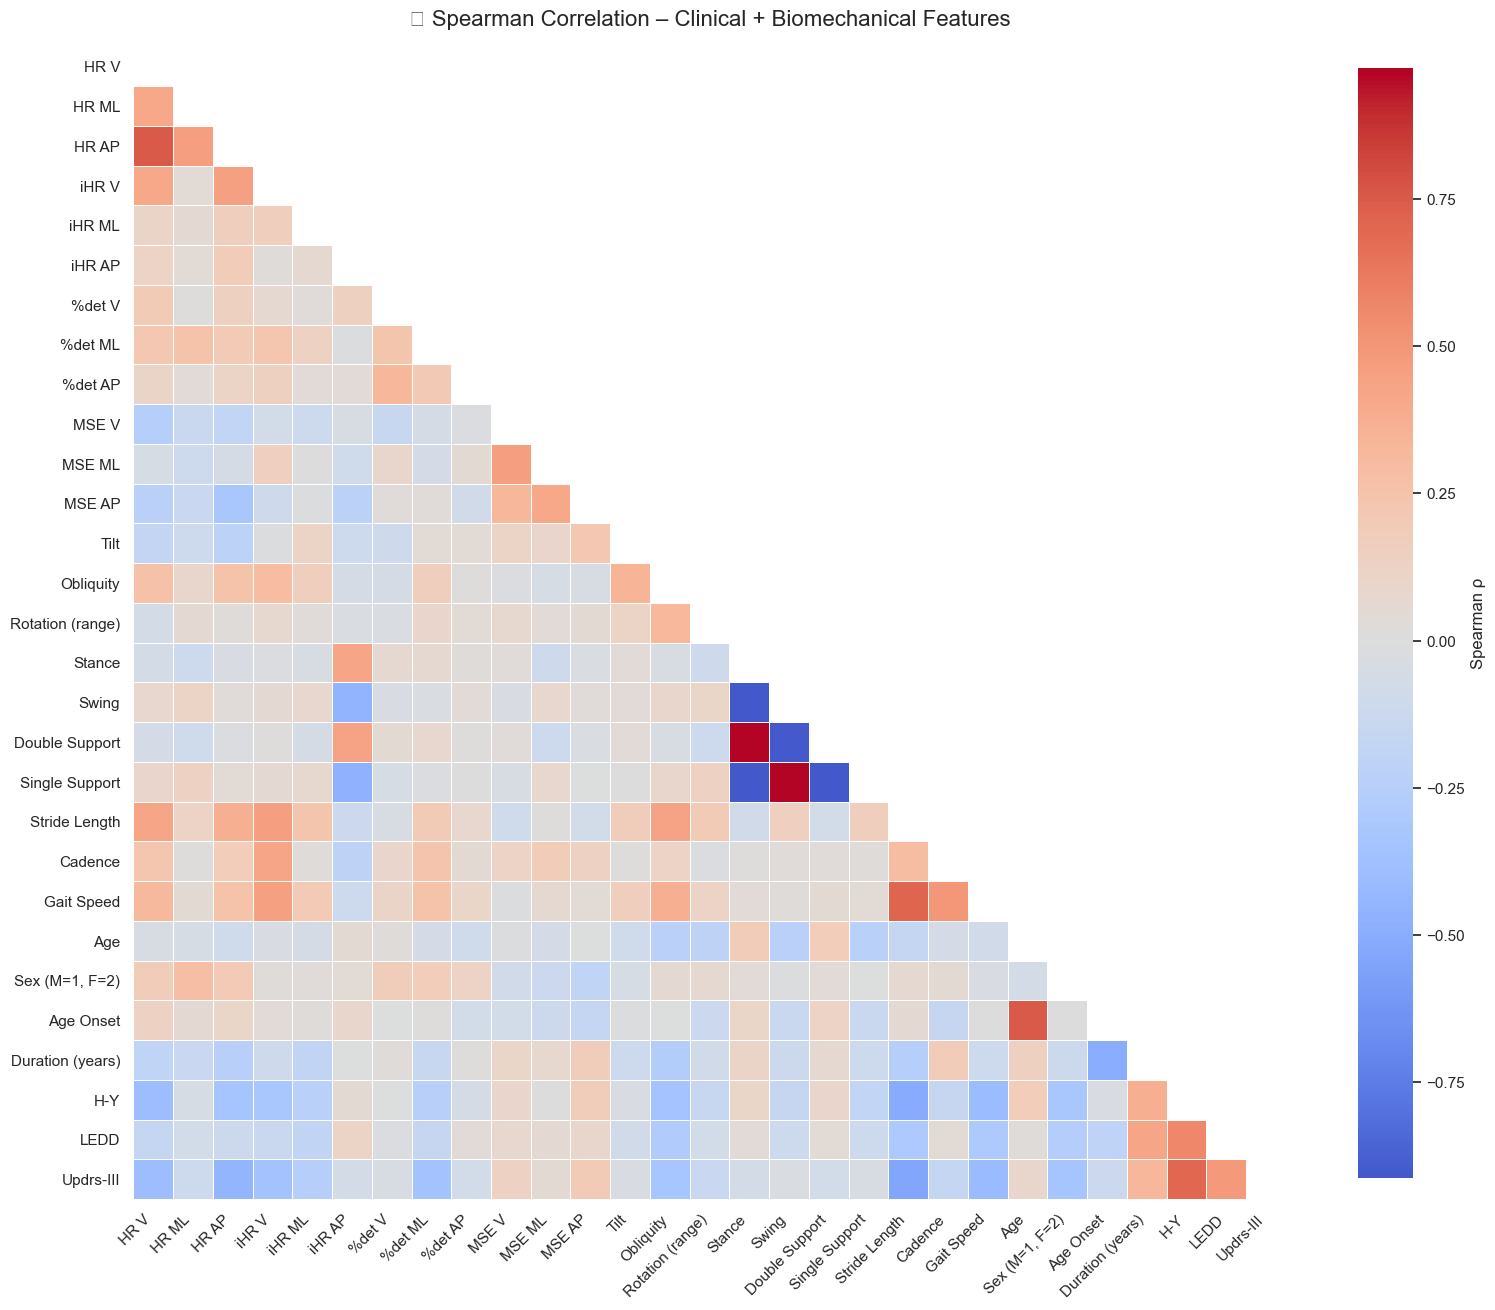

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_excel("../data/raw/final_data_mondinoxicot.xlsx")
df.columns = df.columns.str.strip()

biomech_cols = [
    'HR V', 'HR ML', 'HR AP',
    'iHR V', 'iHR ML', 'iHR AP',
    '%det V', '%det ML', '%det AP',
    'MSE V', 'MSE ML', 'MSE AP',
    'Tilt', 'Obliquity', 'Rotation (range)',
    'Stance', 'Swing', 'Double Support', 'Single Support',
    'Stride Length', 'Cadence', 'Gait Speed'
]

clinical_cols = [
    'Age', 'Sex (M=1, F=2)', 'Age Onset', 'Duration (years)',
    'H-Y', 'LEDD', 'Updrs-III'
]

clinico_biomech_cols = biomech_cols + clinical_cols

df_num = df[clinico_biomech_cols].apply(pd.to_numeric, errors='coerce')

spearman_corr = df_num.corr(method='spearman')

spearman_corr.to_csv("../tables/spearman_corr_clinico_biomech.csv")

mask = np.triu(np.ones_like(spearman_corr, dtype=bool))

plt.figure(figsize=(16, 14))
sns.set(font_scale=1.0)
sns.set_style("white")

ax = sns.heatmap(
    spearman_corr,
    mask=mask,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.85, "label": "Spearman ρ"}
)

plt.title("🧠 Spearman Correlation – Clinical + Biomechanical Features", fontsize=16, pad=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("../figurez/global/heatmap_spearman_clinico_biomech.png", dpi=300)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

df = pd.read_excel("../data/raw/final_data_mondinoxicot.xlsx")
df.columns = df.columns.str.strip()

biomech_cols = [
    'HR V', 'HR ML', 'HR AP',
    'iHR V', 'iHR ML', 'iHR AP',
    '%det V', '%det ML', '%det AP',
    'MSE V', 'MSE ML', 'MSE AP',
    'Tilt', 'Obliquity', 'Rotation (range)',
    'Stance', 'Swing', 'Double Support', 'Single Support',
    'Stride Length', 'Cadence', 'Gait Speed'
]

clinical_cols = [
    'Age', 'Sex (M=1, F=2)', 'Age Onset', 'Duration (years)',
    'H-Y', 'LEDD', 'Updrs-III'
]

all_cols = biomech_cols + clinical_cols

df_num = df[all_cols].apply(pd.to_numeric, errors='coerce')

results = []
for i, col1 in enumerate(all_cols):
    for j, col2 in enumerate(all_cols):
        if j <= i:  # evita duplicati e diagonale
            continue
        s1 = df_num[col1].dropna()
        s2 = df_num[col2].dropna()
        common_idx = s1.index.intersection(s2.index)
        if len(common_idx) > 2:
            rho, p = spearmanr(s1.loc[common_idx], s2.loc[common_idx])
            results.append({
                "Feature_1": col1,
                "Feature_2": col2,
                "Spearman_rho": rho,
                "p_value": p
            })

spearman_df = pd.DataFrame(results)

spearman_df = spearman_df.sort_values(by="Spearman_rho", key=lambda x: x.abs(), ascending=False)

spearman_df.to_csv("../tables/spearman_pairwise.csv", index=False)

print(spearman_df.head(20))

          Feature_1         Feature_2  Spearman_rho        p_value
329           Swing    Single Support      0.972453  2.001738e-173
316          Stance    Double Support      0.962739  2.282099e-155
340  Double Support    Single Support     -0.911911  1.940357e-106
315          Stance             Swing     -0.908705  8.074841e-105
317          Stance    Single Support     -0.907768  3.014297e-104
328           Swing    Double Support     -0.901773  2.332951e-100
1              HR V             HR AP      0.750422   1.805018e-50
386             Age         Age Onset      0.745018   5.640466e-45
362   Stride Length        Gait Speed      0.707866   1.663118e-42
404             H-Y         Updrs-III      0.692797   4.495467e-31
403             H-Y              LEDD      0.562056   4.701564e-23
369   Stride Length         Updrs-III     -0.539997   2.282478e-17
367   Stride Length               H-Y     -0.511850   5.776281e-19
396       Age Onset  Duration (years)     -0.497856   8.200832

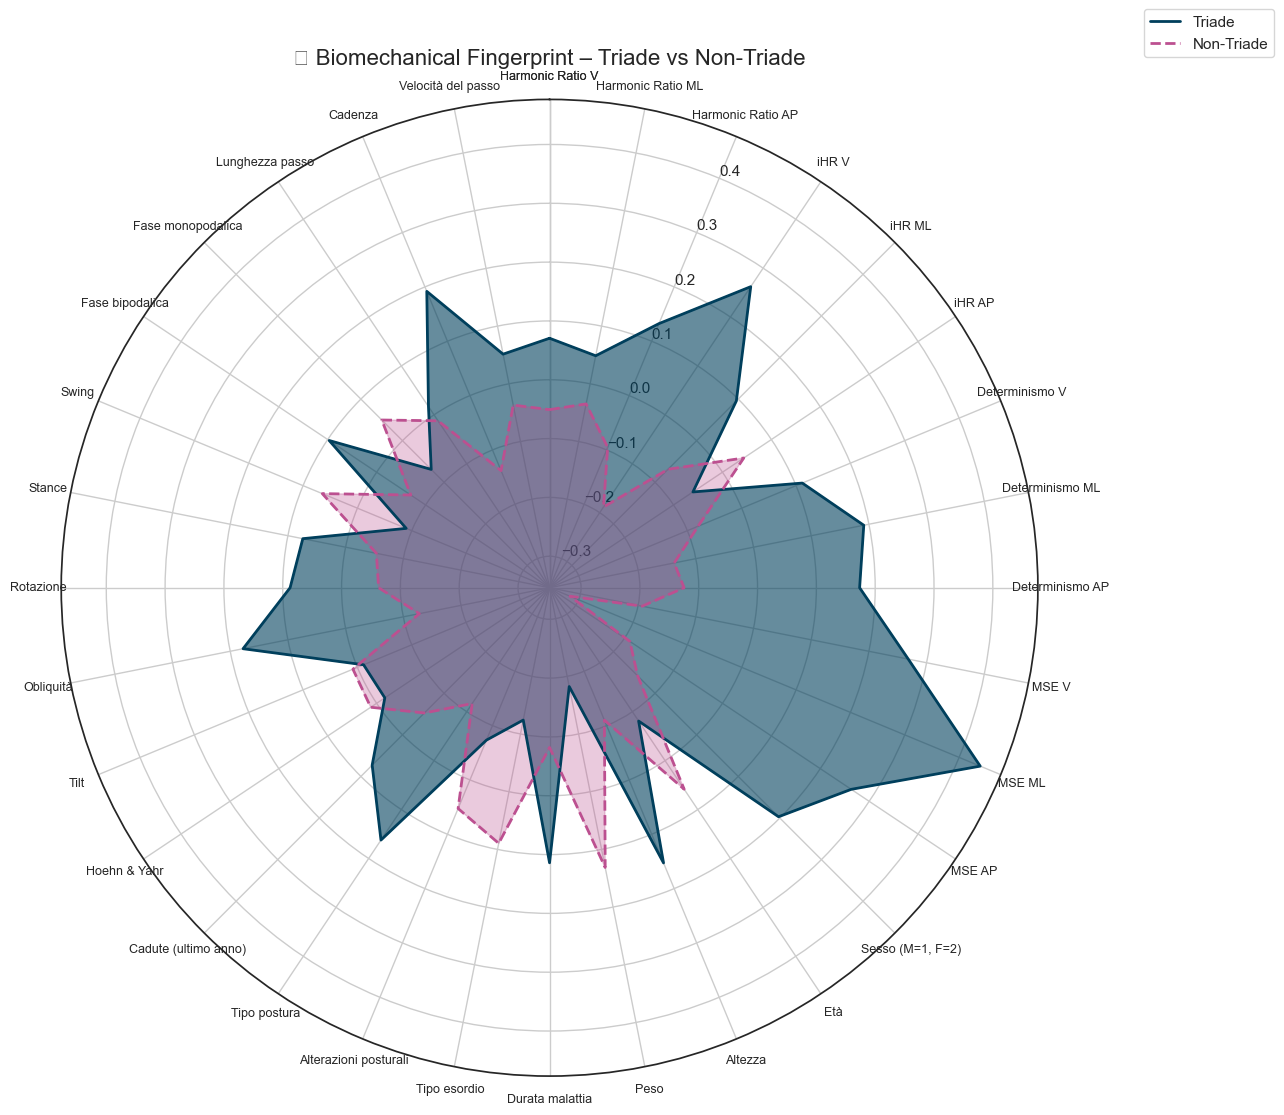

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

df = pd.read_excel("../data/raw/final_data_mondinoxicot.xlsx")
df.columns = df.columns.str.strip()

exclude_cols = [
    'ID', 'Surname', 'Name', 'Center', 'Evaluation Date',
    'Constipation', 'Hyposmia', 'REM', 'Depression', 'ProdromalCount', 'target_bin'
]

all_numeric = df.select_dtypes(include=[np.number]).columns.tolist()
radar_vars = [col for col in all_numeric if col not in exclude_cols]

label_map = {
    'Cadence': 'Cadenza',
    'Gait Speed': 'Velocità del passo',
    'Stride Length': 'Lunghezza passo',
    'Single Support': 'Fase monopodalica',
    'Double Support': 'Fase bipodalica',
    'Swing': 'Swing',
    'Stance': 'Stance',
    'Rotation (range)': 'Rotazione',
    'Obliquity': 'Obliquità',
    'Tilt': 'Tilt',
    'HR V': 'Harmonic Ratio V',
    'HR ML': 'Harmonic Ratio ML',
    'HR AP': 'Harmonic Ratio AP',
    '%det V': 'Determinismo V',
    '%det ML': 'Determinismo ML',
    '%det AP': 'Determinismo AP',
    'Falls last year (1=si, 2=no)': 'Cadute (ultimo anno)',
    'Sex (M=1, F=2)': 'Sesso (M=1, F=2)',
    'Age': 'Età',
    'Heigth': 'Altezza',
    'Weigth': 'Peso',
    'Age Onset': 'Età esordio',
    'Duration (years)': 'Durata malattia',
    'Onset (1=early (<49), 2= middle (5 2-69), 3=late (>7 2) )': 'Tipo esordio',
    'LEDD': 'Dose Levodopa (LEDD)',
    'Updrs-III': 'UPDRS-III',
    'H-Y': 'Hoehn & Yahr',
    'Postural Alteration\n(1=si,2=no)': 'Alterazioni posturali',
    'Camptocromico=1 ,Torre di Pisa=2, Flessione dorsale=3, Inclinazione laterale=4': 'Tipo postura'
}
pretty_labels = [label_map.get(v, v) for v in radar_vars]

df_radar = df[radar_vars + ['target_bin']].dropna()
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_radar[radar_vars]), columns=radar_vars)
df_scaled['target_bin'] = df_radar['target_bin'].values

mean_triade = df_scaled[df_scaled['target_bin'] == 1][radar_vars].mean()
mean_non_triade = df_scaled[df_scaled['target_bin'] == 0][radar_vars].mean()

angles = np.linspace(0, 2 * np.pi, len(radar_vars), endpoint=False).tolist()
angles += angles[:1]
stats_triade = np.append(mean_triade.values, mean_triade.values[0])
stats_non_triade = np.append(mean_non_triade.values, mean_non_triade.values[0])
pretty_labels += [pretty_labels[0]]

fig, ax = plt.subplots(figsize=(13, 13), subplot_kw=dict(polar=True))

ax.plot(angles, stats_triade, color='#003f5c', linewidth=2, linestyle='solid', label='Triade')
ax.fill(angles, stats_triade, color='#003f5c', alpha=0.6)

ax.plot(angles, stats_non_triade, color='#bc5090', linewidth=2, linestyle='dashed', label='Non-Triade')
ax.fill(angles, stats_non_triade, color='#bc5090', alpha=0.3)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

ax.set_thetagrids(np.degrees(angles), pretty_labels, fontsize=9)

for label, angle in zip(ax.get_xticklabels(), angles):
    label.set_horizontalalignment('center')
    label.set_verticalalignment('center')
    label.set_rotation(np.degrees(angle))
    label.set_rotation_mode('anchor')
    label.set_position((1.35, 0))  # distanza aumentata

ax.set_title("🔬 Biomechanical Fingerprint – Triade vs Non-Triade", fontsize=16, pad=25)
ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.1))
plt.tight_layout()
plt.savefig("../figurez/global/radar_signature_all_features_LancetStyle_farlabels.png", dpi=400)
plt.show()

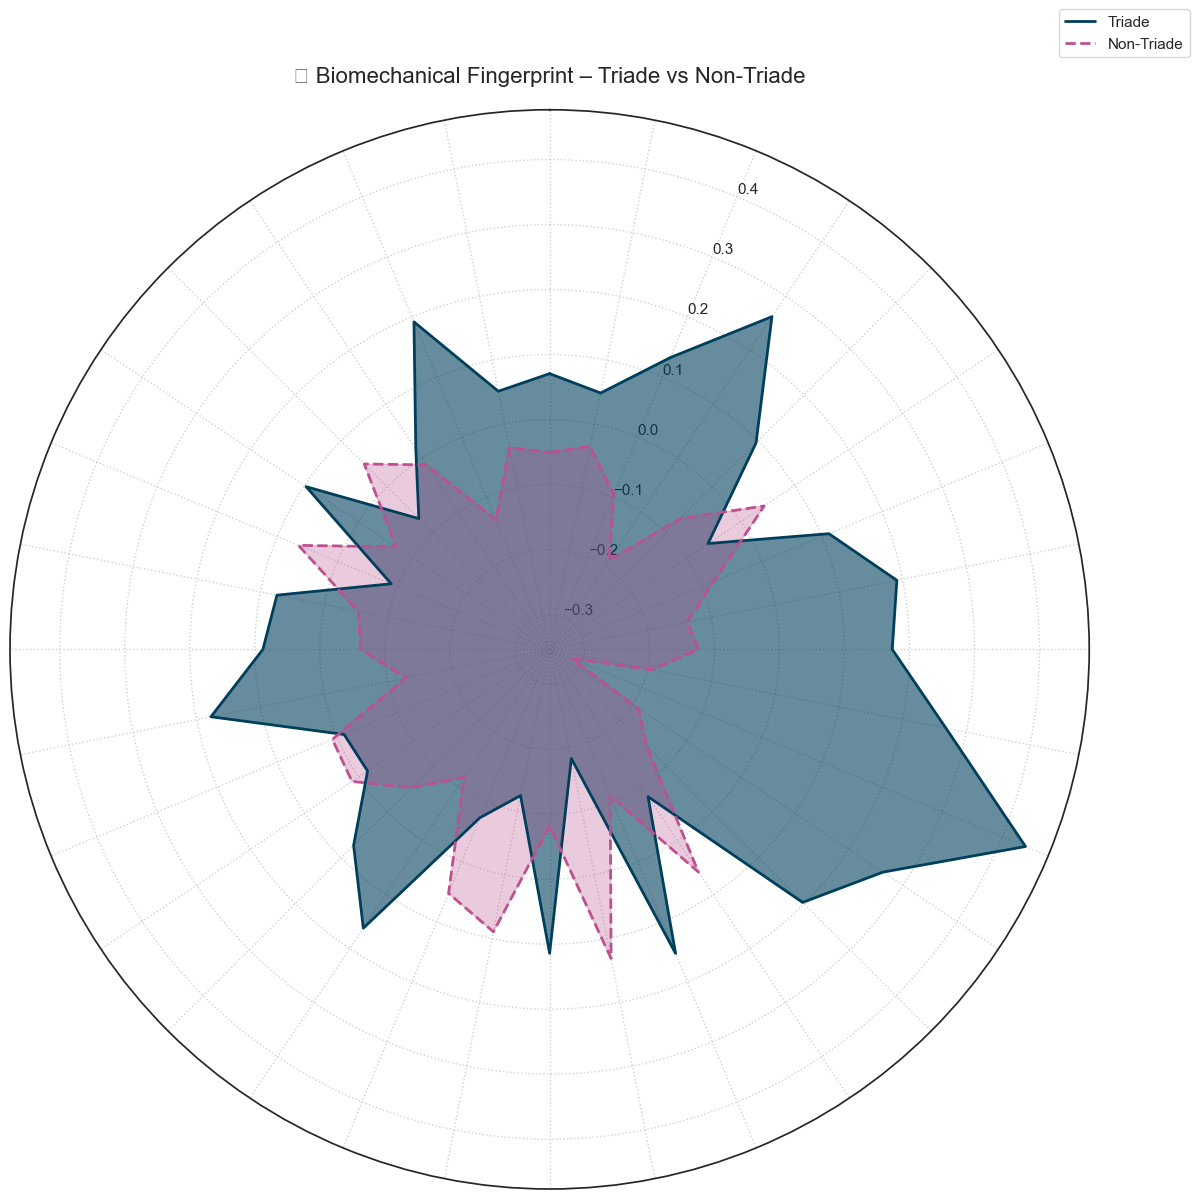

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

df = pd.read_excel("../data/raw/final_data_mondinoxicot.xlsx")
df.columns = df.columns.str.strip()

exclude_cols = [
    'ID','Surname','Name','Center','Evaluation Date',
    'Constipation','Hyposmia','REM','Depression','ProdromalCount','target_bin'
]
all_numeric = df.select_dtypes(include=[np.number]).columns.tolist()
radar_vars = [col for col in all_numeric if col not in exclude_cols]

df_radar = df[radar_vars + ['target_bin']].dropna()
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_radar[radar_vars]), columns=radar_vars)
df_scaled['target_bin'] = df_radar['target_bin'].values

mean_triade = df_scaled[df_scaled['target_bin'] == 1][radar_vars].mean()
mean_non_triade = df_scaled[df_scaled['target_bin'] == 0][radar_vars].mean()

angles = np.linspace(0, 2 * np.pi, len(radar_vars), endpoint=False).tolist()
angles += angles[:1]
stats_triade = np.append(mean_triade.values, mean_triade.values[0])
stats_non_triade = np.append(mean_non_triade.values, mean_non_triade.values[0])

fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(polar=True))

ax.plot(angles, stats_triade, color='#003f5c', linewidth=2, linestyle='solid', label='Triade')
ax.fill(angles, stats_triade, color='#003f5c', alpha=0.6)

ax.plot(angles, stats_non_triade, color='#bc5090', linewidth=2, linestyle='dashed', label='Non-Triade')
ax.fill(angles, stats_non_triade, color='#bc5090', alpha=0.3)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels([])

ax.grid(True, linestyle='dotted', alpha=0.9)

ax.set_title("🔬 Biomechanical Fingerprint – Triade vs Non-Triade", fontsize=16, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

plt.tight_layout()
plt.savefig("../figurez/global/radar_signature_no_labels_with_grid.png", dpi=400)
plt.show()

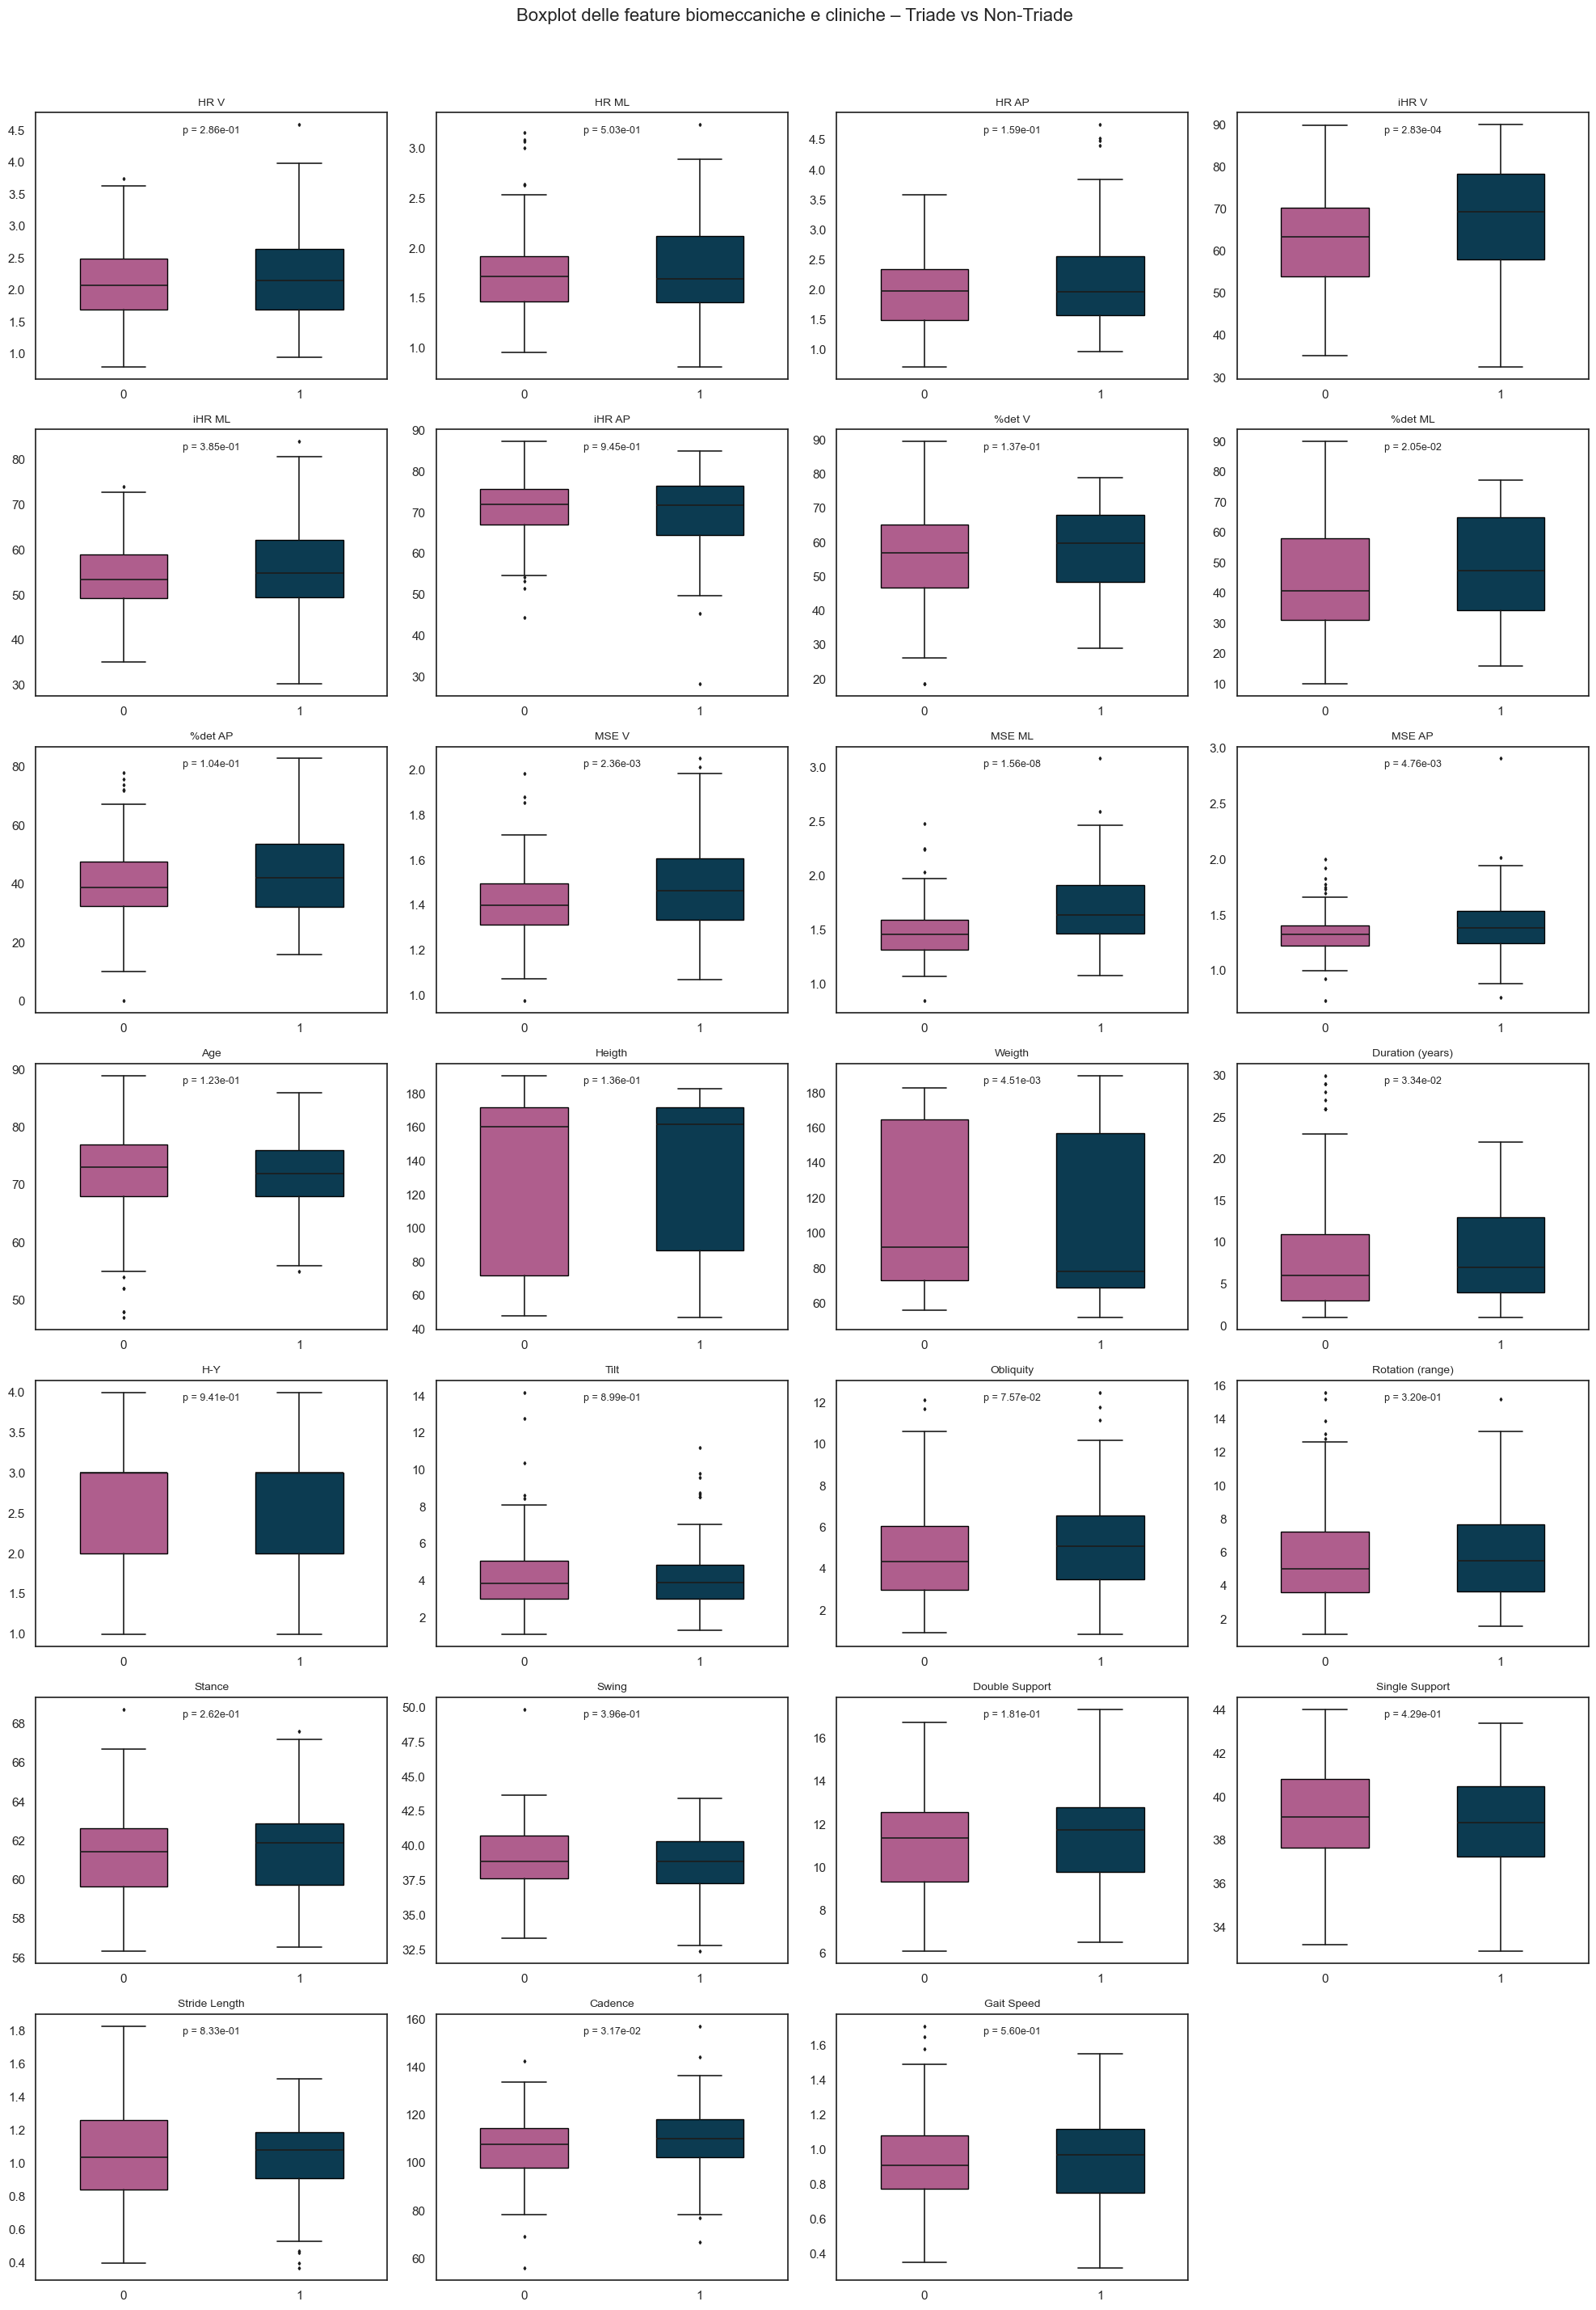

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from math import ceil

df = pd.read_excel("../data/raw/final_data_mondinoxicot.xlsx")
df.columns = df.columns.str.strip()

exclude_exact = [
    'target_bin',
    'ID', 'Surname', 'Name', 'Center', 'Evaluation Date',
    'ProdromalCount', 'REM', 'Hyposmia', 'Depression', 'Constipation',
    'Sex (M=1, F=2)',
    'Onset (1=early (<49), 2= middle (5 2-69), 3=late (>7 2) )',
    'Falls last year (1=si, 2=no)',
    'Camptocromico=1 ,Torre di Pisa=2, Flessione dorsale=3, Inclinazione laterale=4',
    'Postural Alteration\n(1=si,2=no)'
]

numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
features = [col for col in numeric_cols if col not in exclude_exact]

palette = {0: "#bc5090", 1: "#003f5c"}

n_cols = 4
n_rows = ceil(len(features) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]
    sns.boxplot(
        data=df, x='target_bin', y=feature,
        palette=palette, ax=ax, linewidth=1.2, width=0.5,
        fliersize=2, boxprops=dict(edgecolor='black', linewidth=1)
    )
    ax.set_title(feature, fontsize=10)
    ax.set_xlabel("")
    ax.set_ylabel("")

    group_0 = df[df['target_bin'] == 0][feature].dropna()
    group_1 = df[df['target_bin'] == 1][feature].dropna()
    if len(group_0) > 0 and len(group_1) > 0:
        stat, p = mannwhitneyu(group_0, group_1, alternative='two-sided')
        ax.text(0.5, 0.95, f"p = {p:.2e}", ha='center', va='top', transform=ax.transAxes, fontsize=9)
    else:
        ax.text(0.5, 0.95, "N/A", ha='center', va='top', transform=ax.transAxes, fontsize=9)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Boxplot delle feature biomeccaniche e cliniche – Triade vs Non-Triade", fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig("../figurez/global/boxplot_all_features_refined_LancetStyle.png", dpi=400)
plt.show()

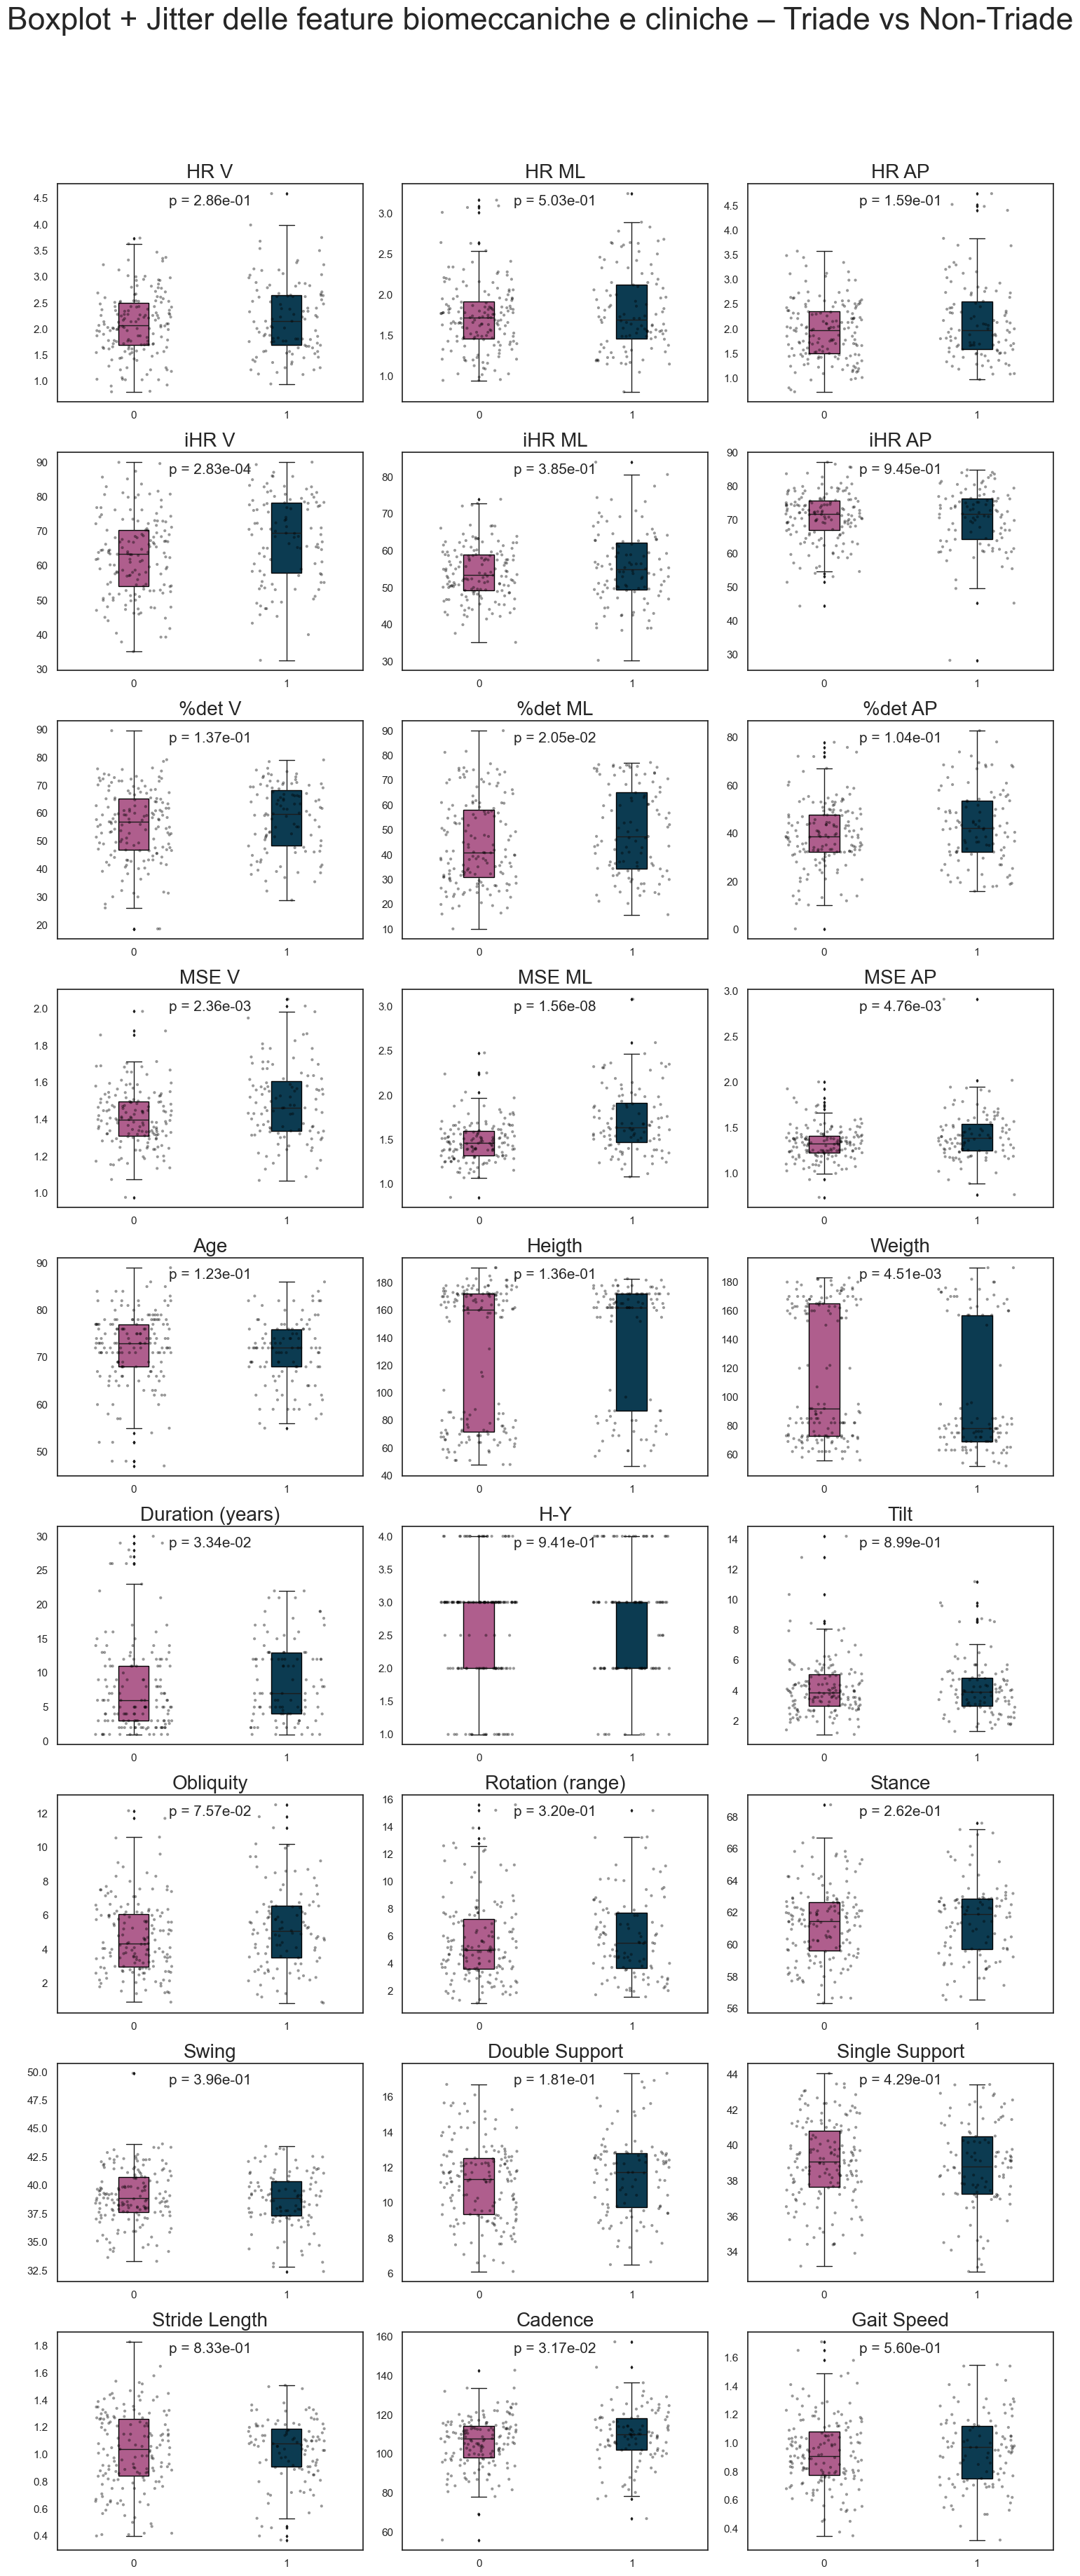

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from math import ceil

df = pd.read_excel("../data/raw/final_data_mondinoxicot.xlsx")
df.columns = df.columns.str.strip()

exclude_exact = [
    'target_bin',
    'ID', 'Surname', 'Name', 'Center', 'Evaluation Date',
    'ProdromalCount', 'REM', 'Hyposmia', 'Depression', 'Constipation',
    'Sex (M=1, F=2)',
    'Onset (1=early (<49), 2= middle (5 2-69), 3=late (>7 2) )',
    'Falls last year (1=si, 2=no)',
    'Camptocromico=1 ,Torre di Pisa=2, Flessione dorsale=3, Inclinazione laterale=4',
    'Postural Alteration\n(1=si,2=no)'
]

numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
features = [col for col in numeric_cols if col not in exclude_exact]

palette = {0: "#bc5090", 1: "#003f5c"}  # rosa e blu

n_cols = 3
n_rows = ceil(len(features) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]

    sns.boxplot(
        data=df, x='target_bin', y=feature,
        palette=palette, ax=ax,
        linewidth=1, width=0.2,  # box più stretti
        fliersize=2, boxprops=dict(edgecolor='black', linewidth=1)
    )

    sns.stripplot(
        data=df, x='target_bin', y=feature,
        ax=ax, color='black', alpha=0.4,
        size=3, jitter=0.25
    )

    ax.set_title(feature, fontsize=20)
    ax.set_xlabel("")
    ax.set_ylabel("")

    group_0 = df[df['target_bin'] == 0][feature].dropna()
    group_1 = df[df['target_bin'] == 1][feature].dropna()
    if len(group_0) > 0 and len(group_1) > 0:
        stat, p = mannwhitneyu(group_0, group_1, alternative='two-sided')
        ax.text(0.5, 0.95, f"p = {p:.2e}", ha='center', va='top',
                transform=ax.transAxes, fontsize=15)
    else:
        ax.text(0.5, 0.95, "N/A", ha='center', va='top',
                transform=ax.transAxes, fontsize=15)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Boxplot + Jitter delle feature biomeccaniche e cliniche – Triade vs Non-Triade",
             fontsize=32, y=1.02)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig("../figurez/global/boxplot_all_features_refined_LancetStyle_jitter.png", dpi=400)
plt.show()

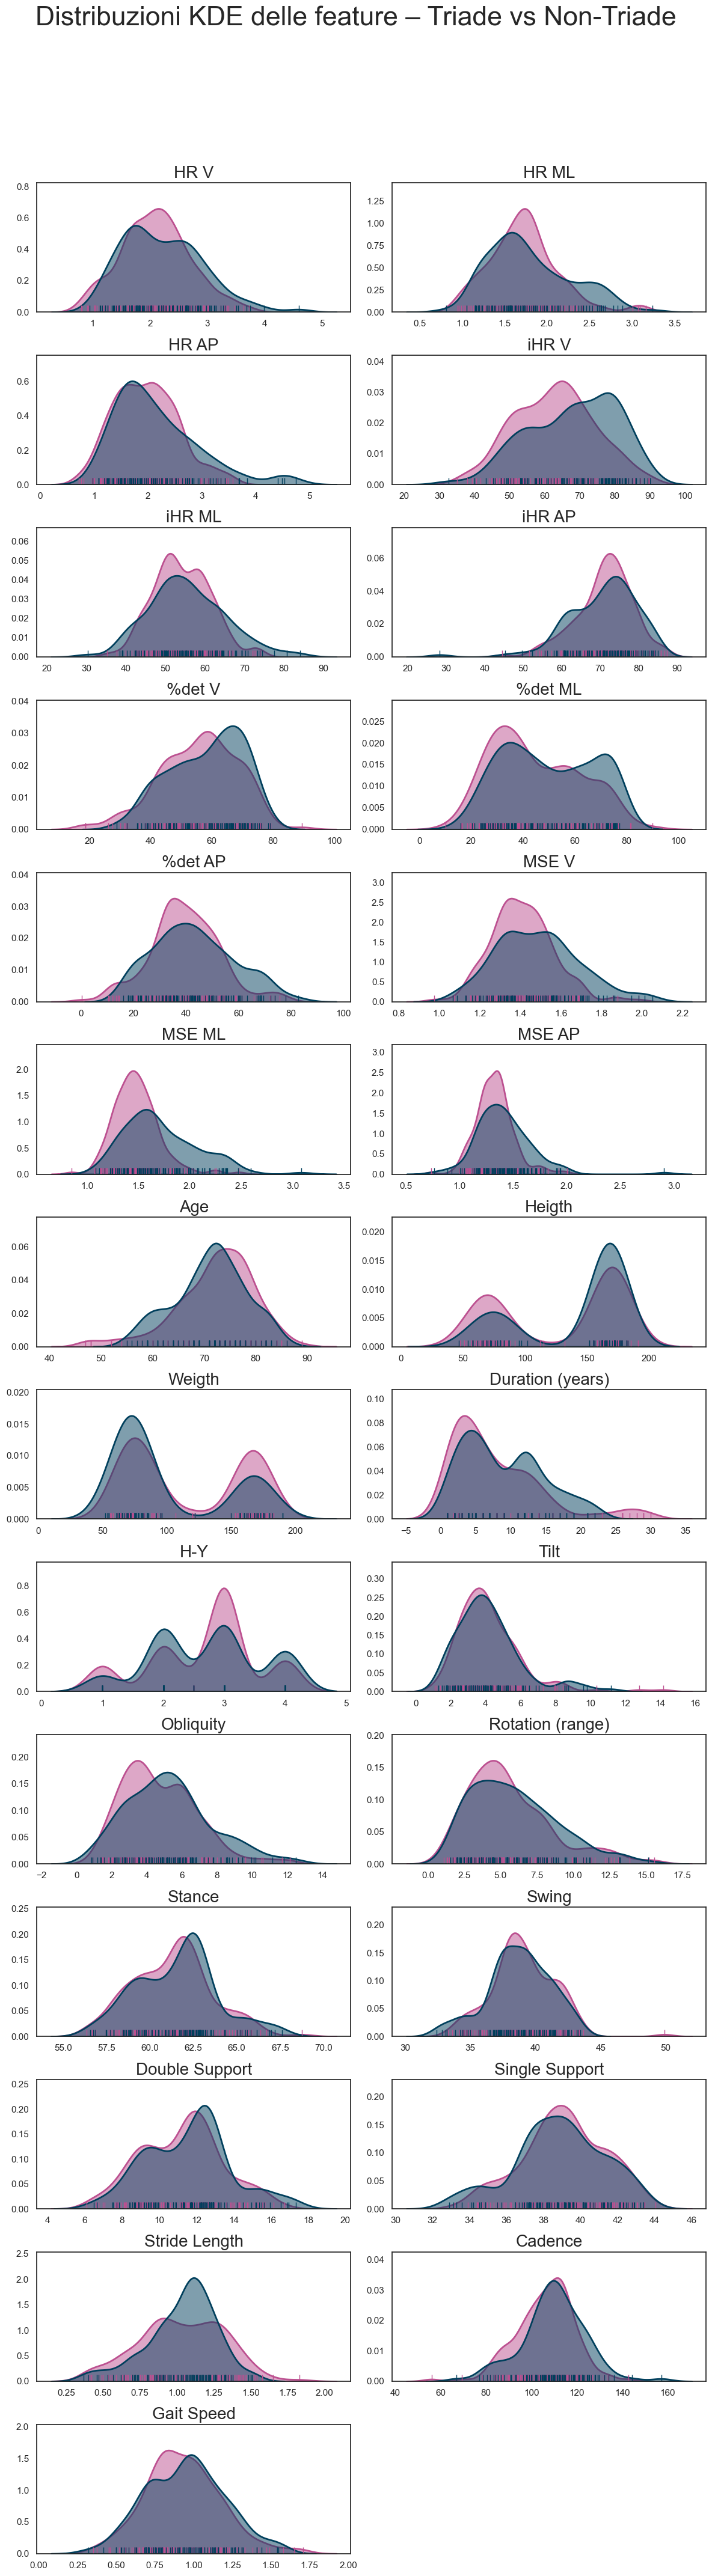

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

df = pd.read_excel("../data/raw/final_data_mondinoxicot.xlsx")
df.columns = df.columns.str.strip()

exclude_exact = [
    'target_bin',
    'ID', 'Surname', 'Name', 'Center', 'Evaluation Date',
    'ProdromalCount', 'REM', 'Hyposmia', 'Depression', 'Constipation',
    'Sex (M=1, F=2)',
    'Onset (1=early (<49), 2= middle (5 2-69), 3=late (>7 2) )',
    'Falls last year (1=si, 2=no)',
    'Camptocromico=1 ,Torre di Pisa=2, Flessione dorsale=3, Inclinazione laterale=4',
    'Postural Alteration\n(1=si,2=no)'
]

numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
features = [col for col in numeric_cols if col not in exclude_exact]

palette = {0: "#bc5090", 1: "#003f5c"}

n_cols = 2
n_rows = ceil(len(features) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*6, n_rows*3))
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]

    for group in [0, 1]:
        data_group = df[df['target_bin'] == group][feature].dropna()

        sns.kdeplot(
            data=data_group,
            fill=True,
            bw_adjust=0.8,
            common_norm=False,
            color=palette[group],
            alpha=0.5,
            linewidth=2,
            ax=ax,
            label=f"Triade {group}"
        )

        sns.rugplot(
            data=data_group,
            color=palette[group],
            height=0.05,
            lw=1,
            ax=ax
        )

    ax.set_title(feature, fontsize=20)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.legend().set_visible(False)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Distribuzioni KDE delle feature – Triade vs Non-Triade", fontsize=32, y=1.02)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig("../figurez/global/kde_distributions_all_features_Triade_vs_NonTriade_Rug.png", dpi=400)
plt.show()

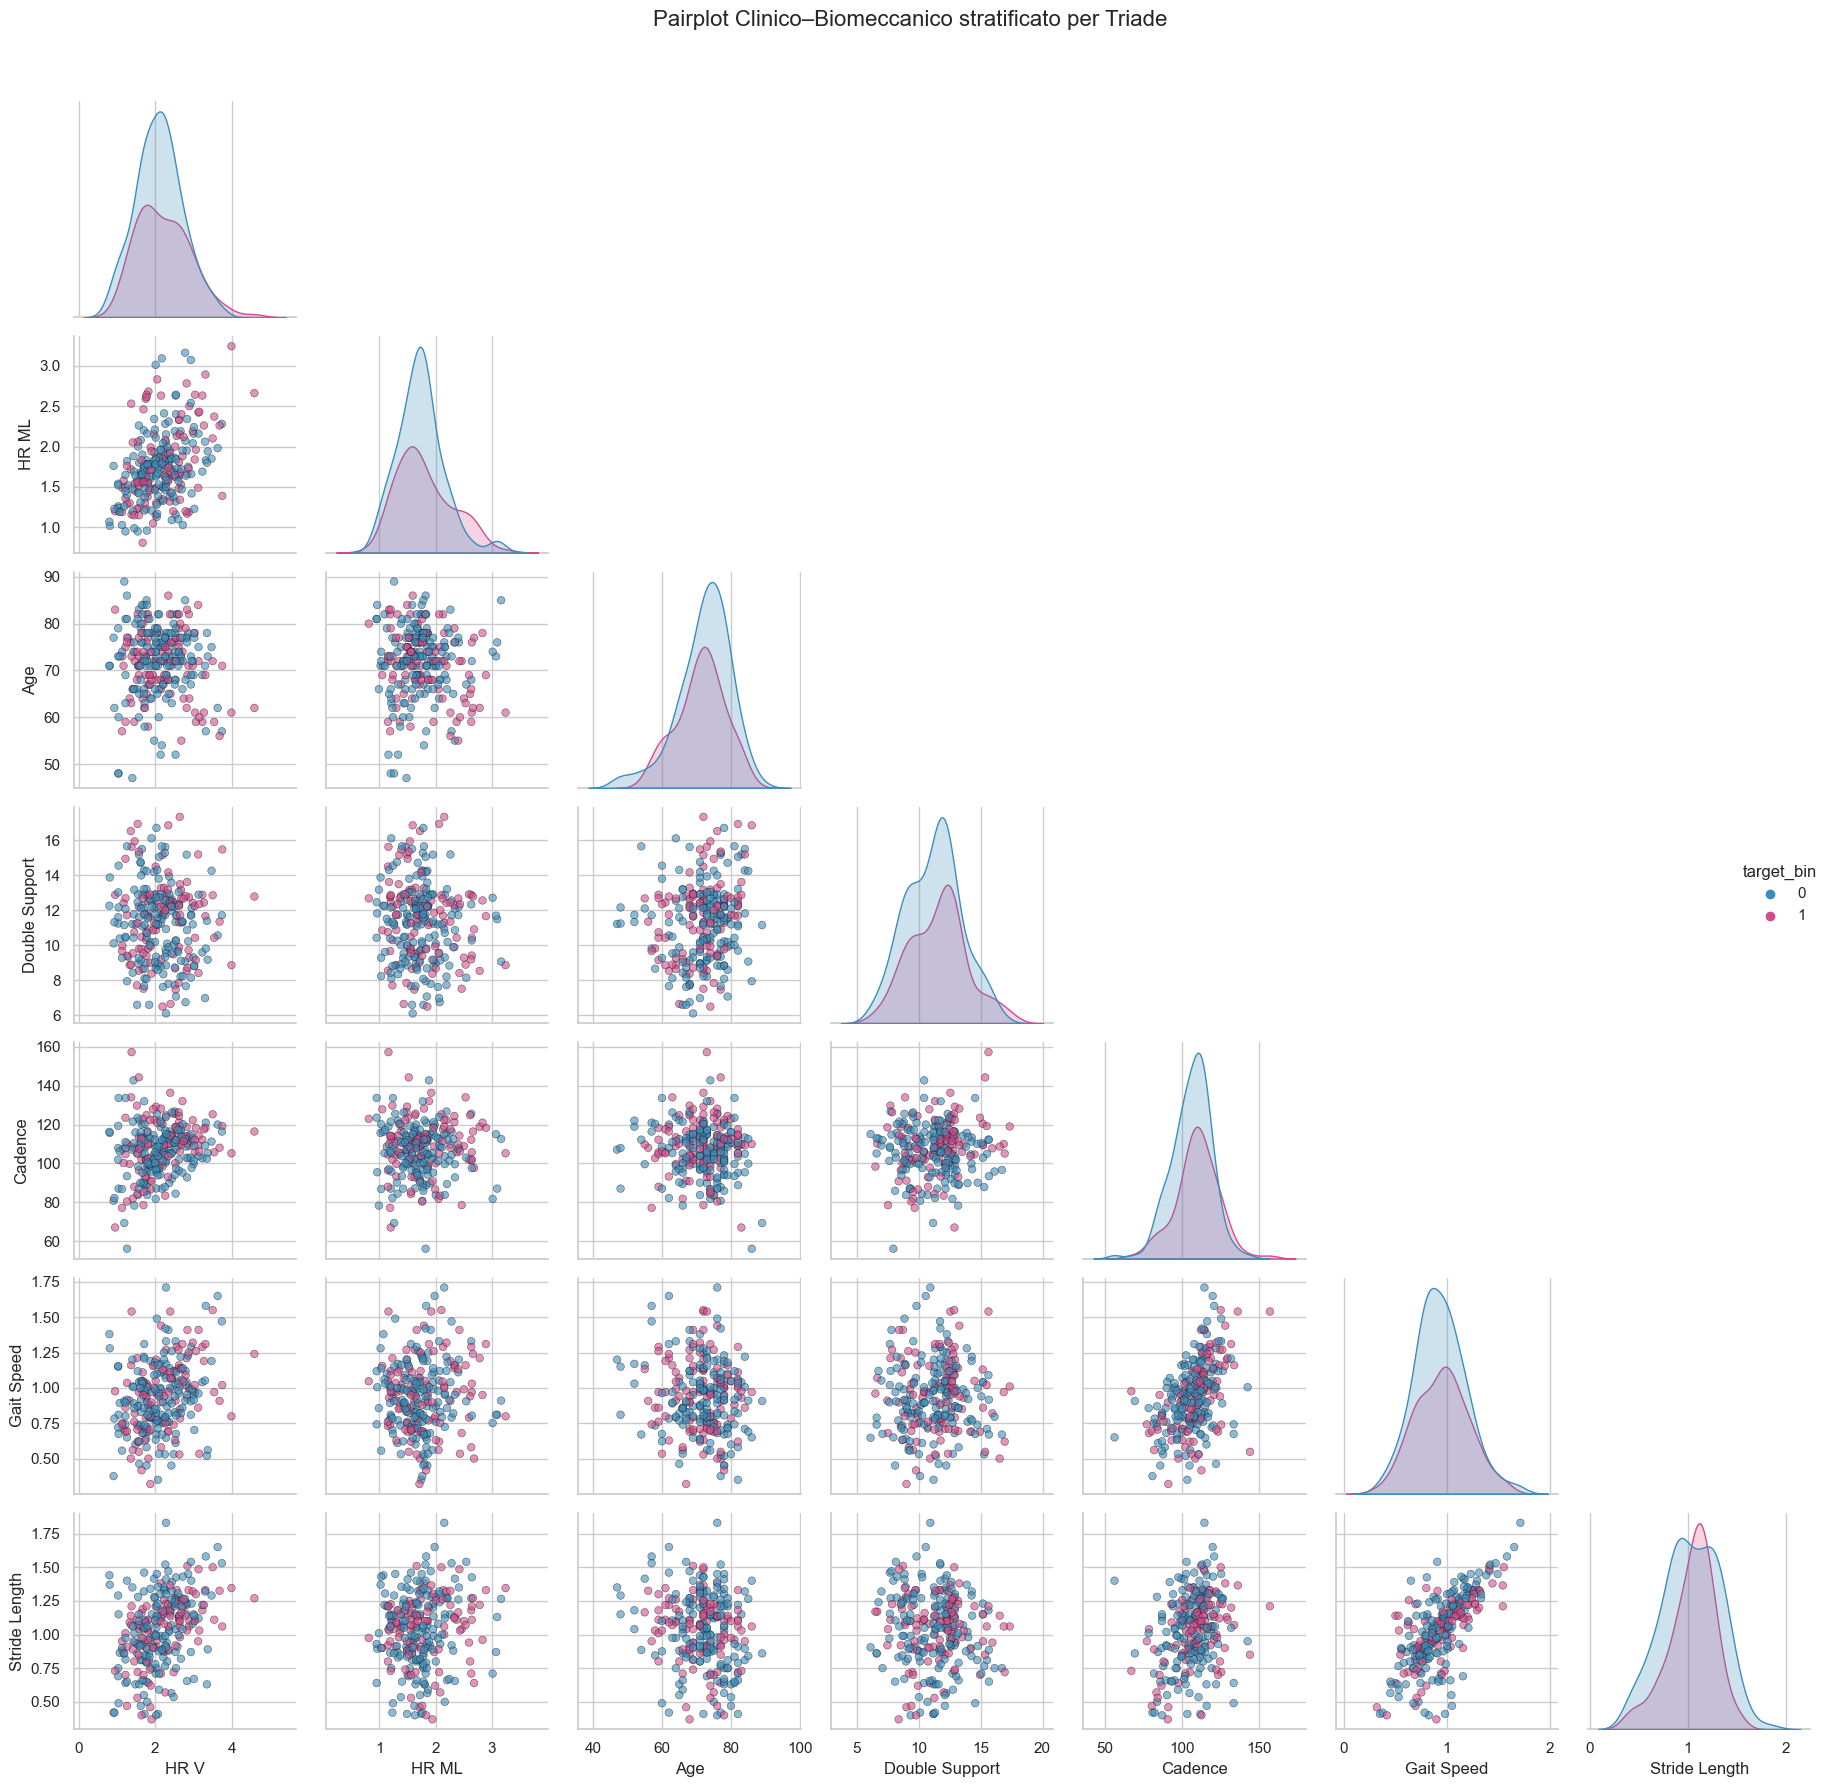

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

df = pd.read_excel("../data/raw/final_data_mondinoxicot.xlsx")
df.columns = df.columns.str.strip()

features_pairplot = [
    'HR V', 'HR ML', 'Age', 'Updrs-III',
    'Double Support', 'Cadence', 'Gait Speed', 'Stride Length'
]

output_dir = "../figurez/global"
os.makedirs(output_dir, exist_ok=True)

sns.set(style="whitegrid", context="notebook")
pairplot = sns.pairplot(
    df[features_pairplot + ['target_bin']],
    hue='target_bin',
    palette={0: "#3C8DBC", 1: "#D24C8C"},
    diag_kind="kde",
    corner=True,
    plot_kws={'alpha': 0.6, 's': 30, 'edgecolor': 'k'},
    diag_kws={'shade': True}
)

pairplot.fig.suptitle("Pairplot Clinico–Biomeccanico stratificato per Triade", fontsize=16, y=1.02)
pairplot.fig.tight_layout()
pairplot.savefig(os.path.join(output_dir, "pairplot_clinico_biomeccanico.png"), dpi=400)

plt.show()

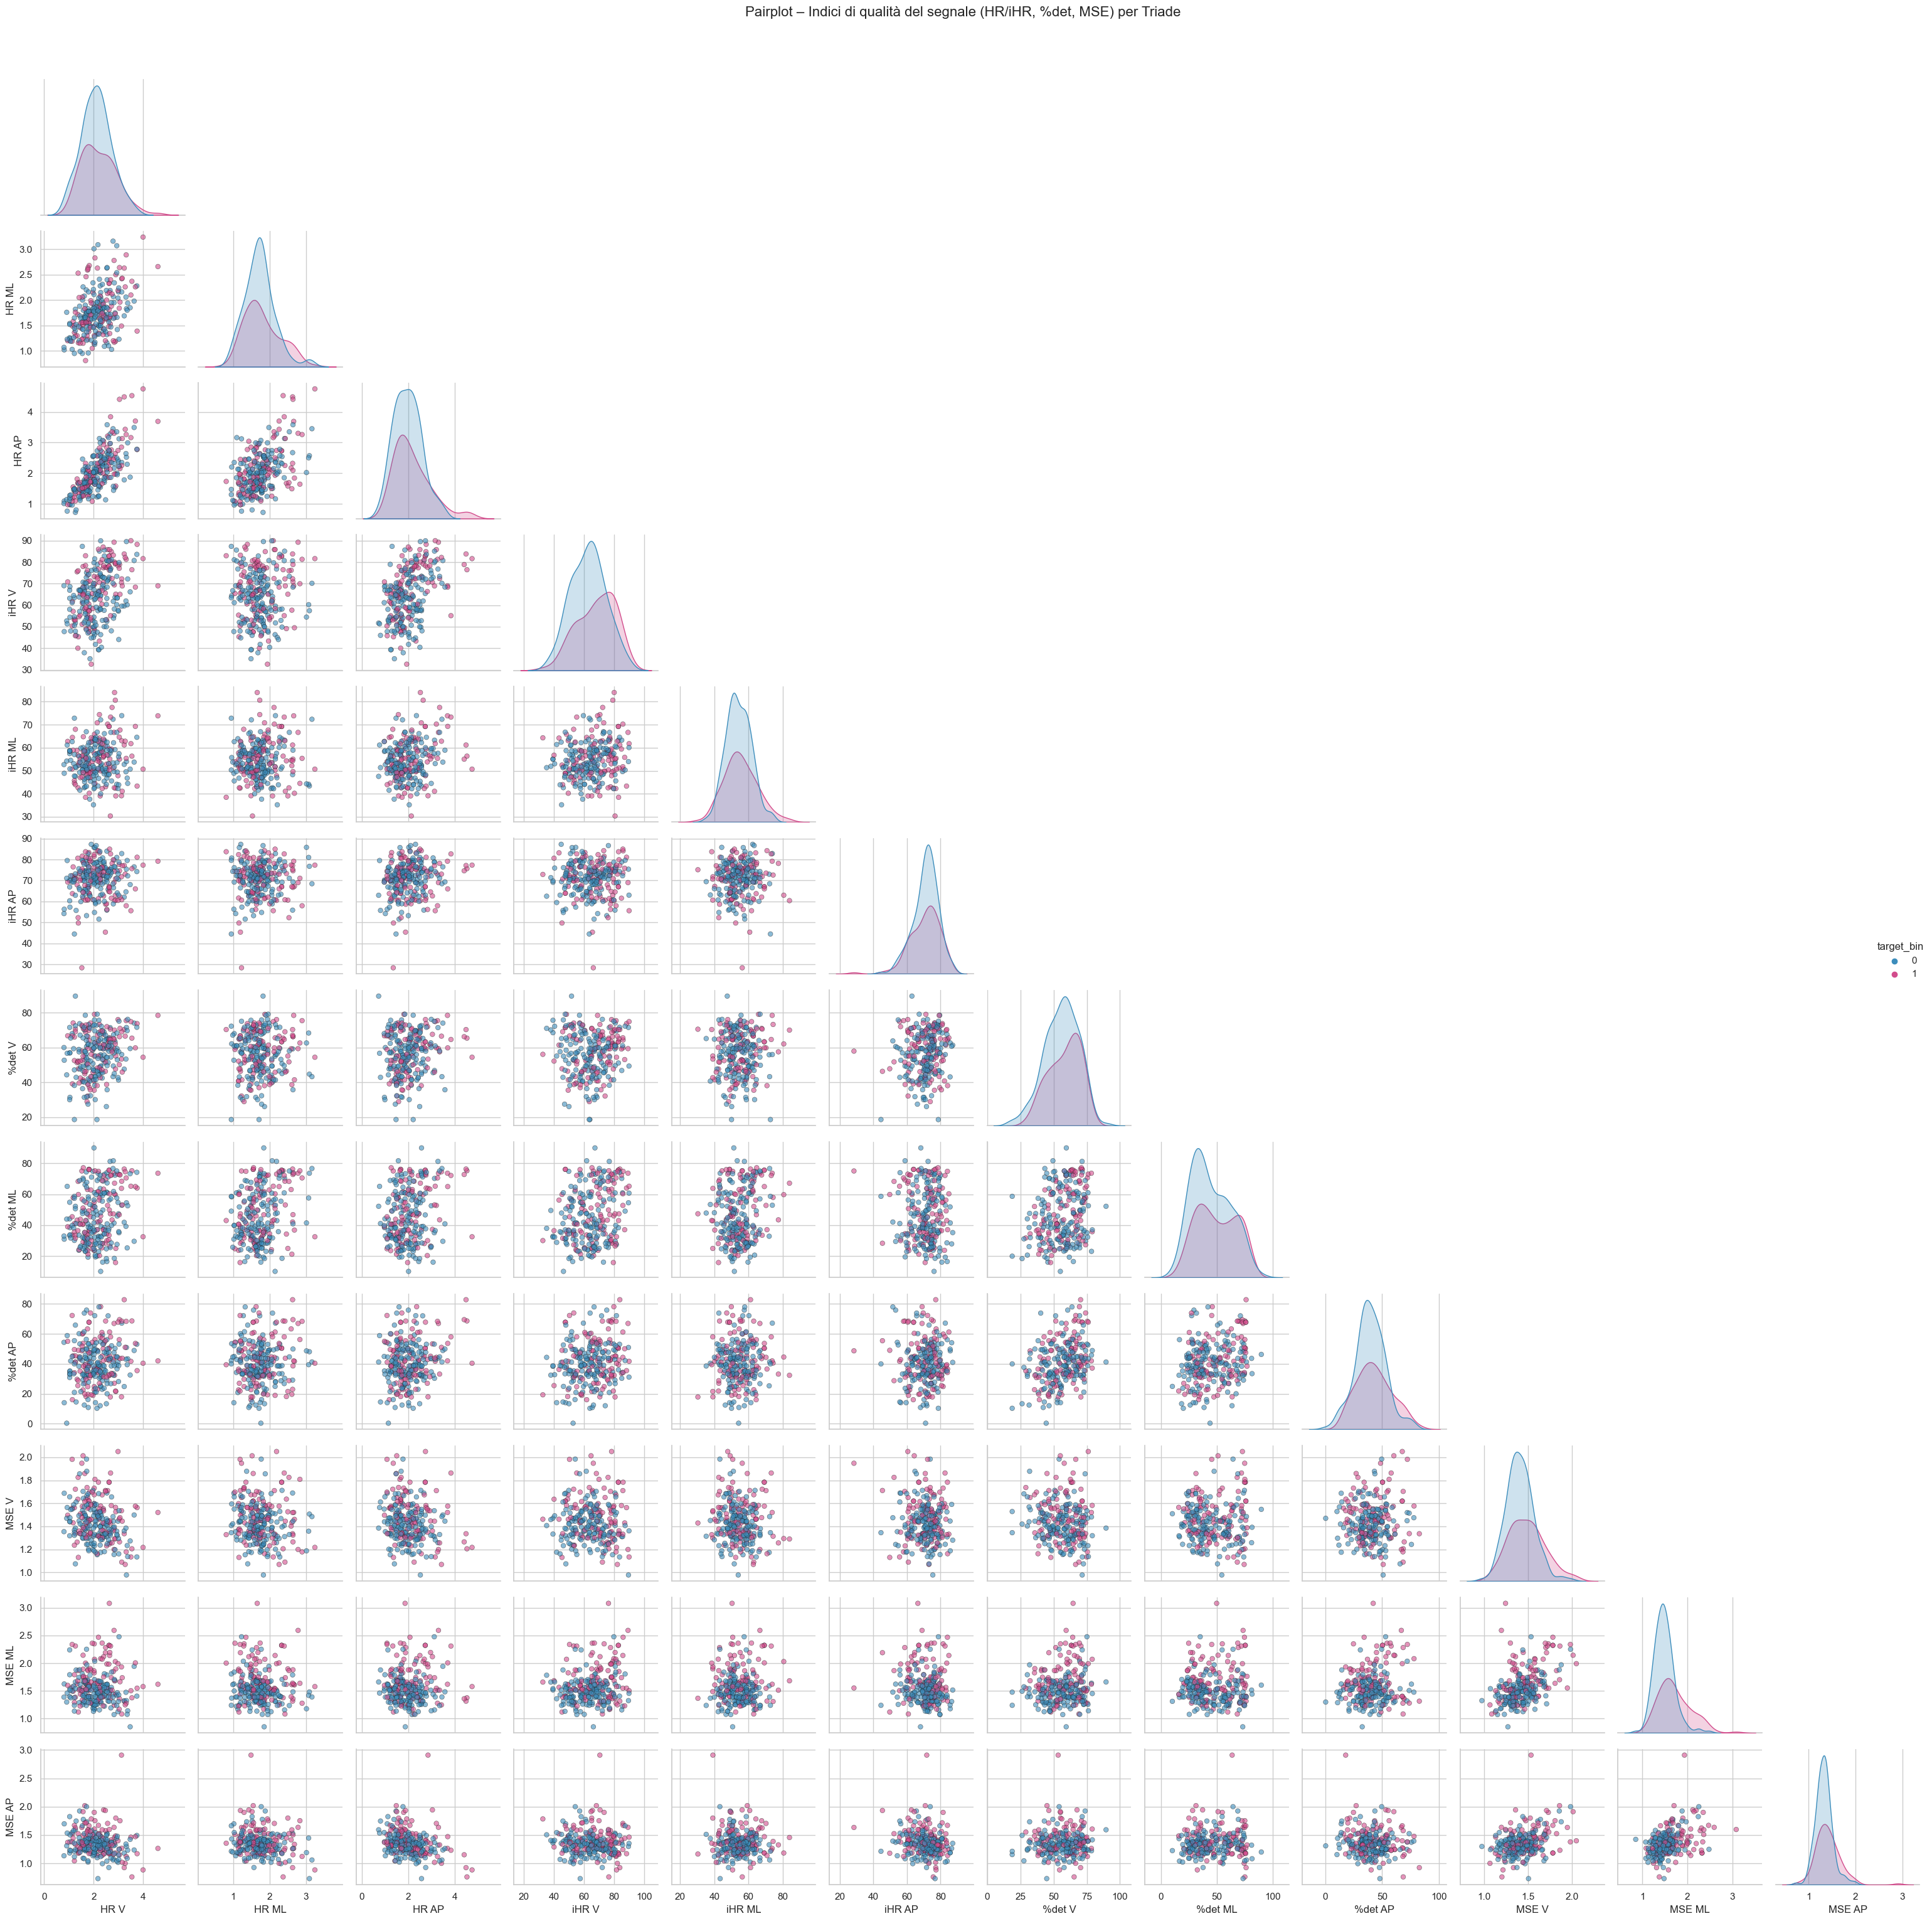

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# 🔹 Caricamento dati
df = pd.read_excel("../data/raw/final_data_mondinoxicot.xlsx")
df.columns = df.columns.str.strip()

# 🔹 Selezione: indici di qualità del segnale
features_pairplot = [
    'HR V', 'HR ML', 'HR AP',
    'iHR V', 'iHR ML', 'iHR AP',
    '%det V', '%det ML', '%det AP',
    'MSE V', 'MSE ML', 'MSE AP'
]

# 🔹 Coercizza a numerico (eventuali stringhe -> NaN)
df[features_pairplot] = df[features_pairplot].apply(pd.to_numeric, errors='coerce')

# 🔹 Output dir
output_dir = "../figurez/global"
os.makedirs(output_dir, exist_ok=True)

# 🔹 Pairplot
sns.set(style="whitegrid", context="notebook")
pairplot = sns.pairplot(
    df[features_pairplot + ['target_bin']],
    hue='target_bin',
    palette={0: "#3C8DBC", 1: "#D24C8C"},
    diag_kind="kde",
    corner=True,
    plot_kws={'alpha': 0.6, 's': 30, 'edgecolor': 'k'},
    diag_kws={'shade': True}
)

# 🔹 Titolo e salvataggio
pairplot.fig.suptitle("Pairplot – Indici di qualità del segnale (HR/iHR, %det, MSE) per Triade", fontsize=16, y=1.02)
pairplot.fig.tight_layout()
pairplot.savefig(os.path.join(output_dir, "pairplot_signal_quality.png"), dpi=400)

plt.show()

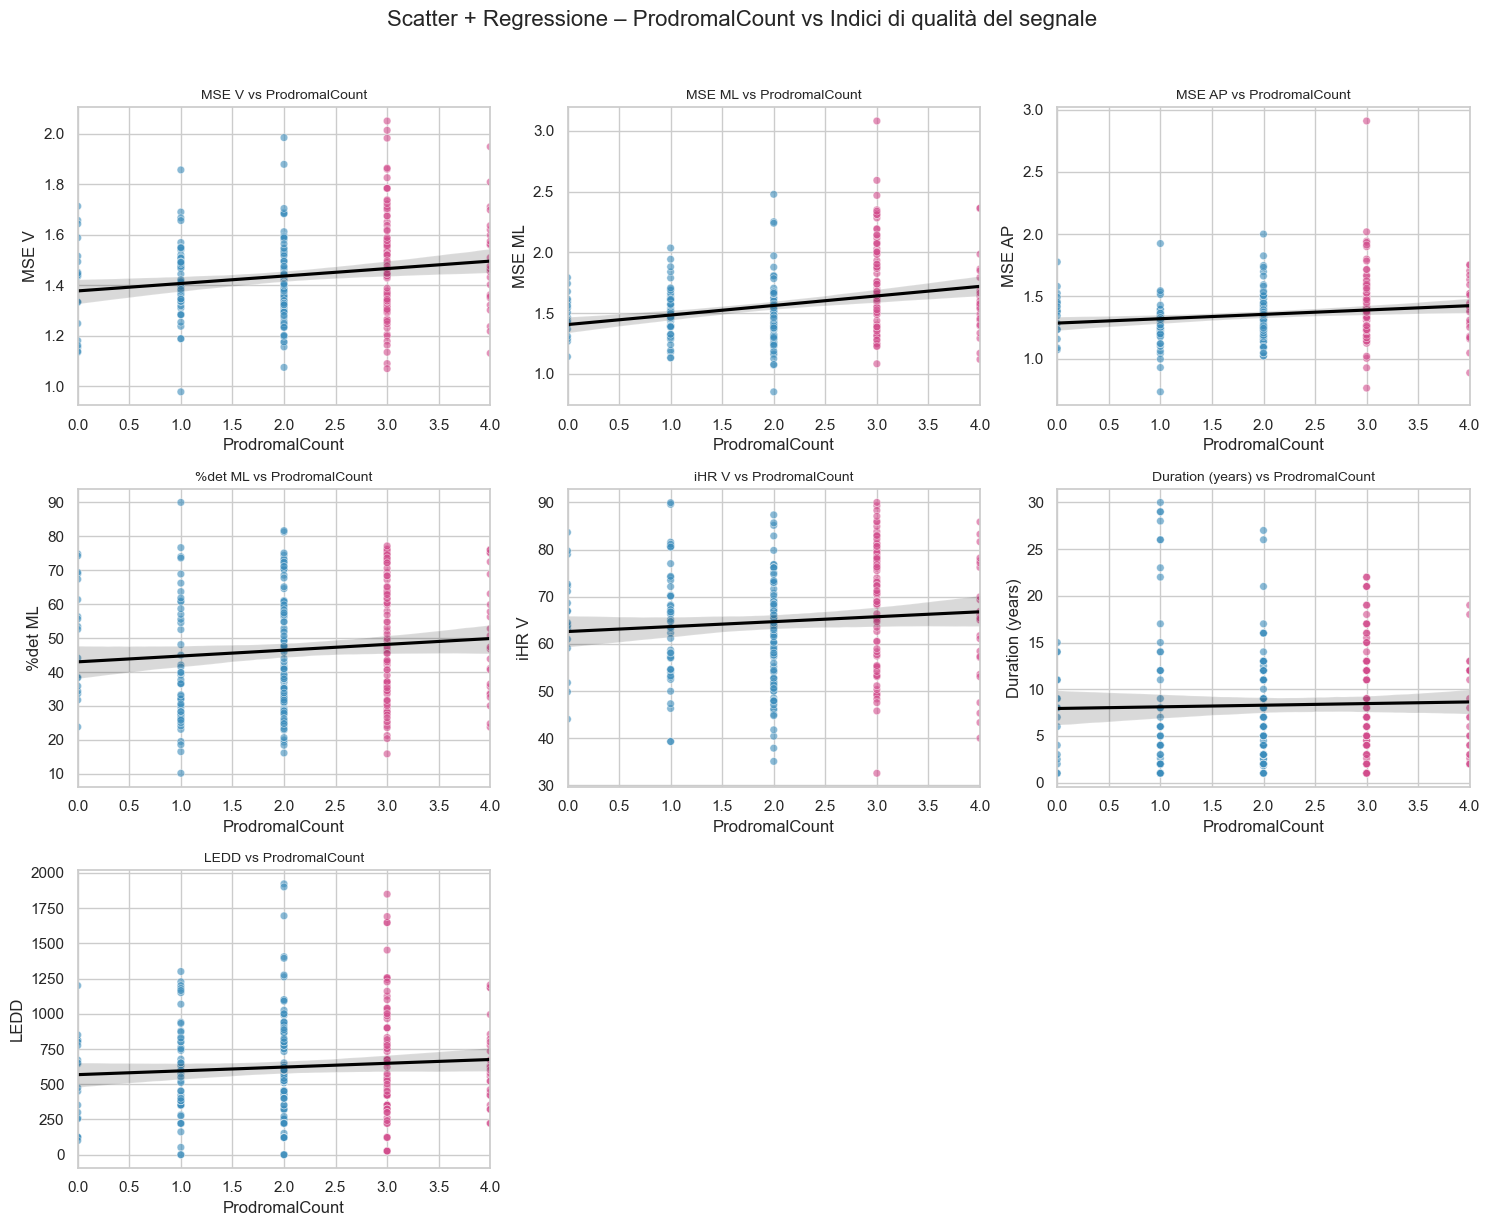

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil
import os

df = pd.read_excel("../data/raw/final_data_mondinoxicot.xlsx")
df.columns = df.columns.str.strip()

os.makedirs("../figurez/global", exist_ok=True)

biomech_features = [
    "MSE V", "MSE ML", "MSE AP",
    "%det ML",
    "iHR V",
    "Duration (years)", "LEDD"
]

cols_to_num = biomech_features + ["ProdromalCount", "target_bin"]
df[cols_to_num] = df[cols_to_num].apply(pd.to_numeric, errors="coerce")

palette = {0: "#3C8DBC", 1: "#D24C8C"}  # 0=Non-Triade (blu), 1=Triade (rosa)

n_cols = 3
n_rows = ceil(len(biomech_features) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

for i, feature in enumerate(biomech_features):
    ax = axes[i]
    sns.scatterplot(
        data=df,
        x="ProdromalCount",
        y=feature,
        hue="target_bin",
        palette=palette,
        alpha=0.6,
        s=30,
        ax=ax
    )
    sns.regplot(
        data=df,
        x="ProdromalCount",
        y=feature,
        scatter=False,
        color="black",
        ax=ax
    )
    ax.set_title(f"{feature} vs ProdromalCount", fontsize=10)
    ax.legend_.remove()

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Scatter + Regressione – ProdromalCount vs Indici di qualità del segnale", fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig("../output/eda/scatter_prodrome_vs_signalquality.png", dpi=300)
plt.show()


📊 Spearman correlation vs ProdromalCount
   Feature  Spearman_rho   p_value
1   MSE ML      0.267138  0.000012
2   MSE AP      0.172660  0.005157
0    MSE V      0.154412  0.012503
3  %det ML      0.127392  0.038224
4    iHR V      0.125814  0.041476

📊 Regressioni lineari parziali (Feature ~ ProdromalCount + Age + H-Y + GaitSpeed)

--- MSE V ---
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.4285      0.128     11.149      0.000       1.176       1.681
ProdromalCount     0.0329      0.011      3.016      0.003       0.011       0.054
Age               -0.0016      0.002     -1.037      0.301      -0.005       0.001
H-Y                0.0153      0.015      1.045      0.297      -0.014       0.044
Gait Speed         0.0132      0.050      0.263      0.792      -0.086       0.112

--- MSE ML ---
                     coef    std err          t      

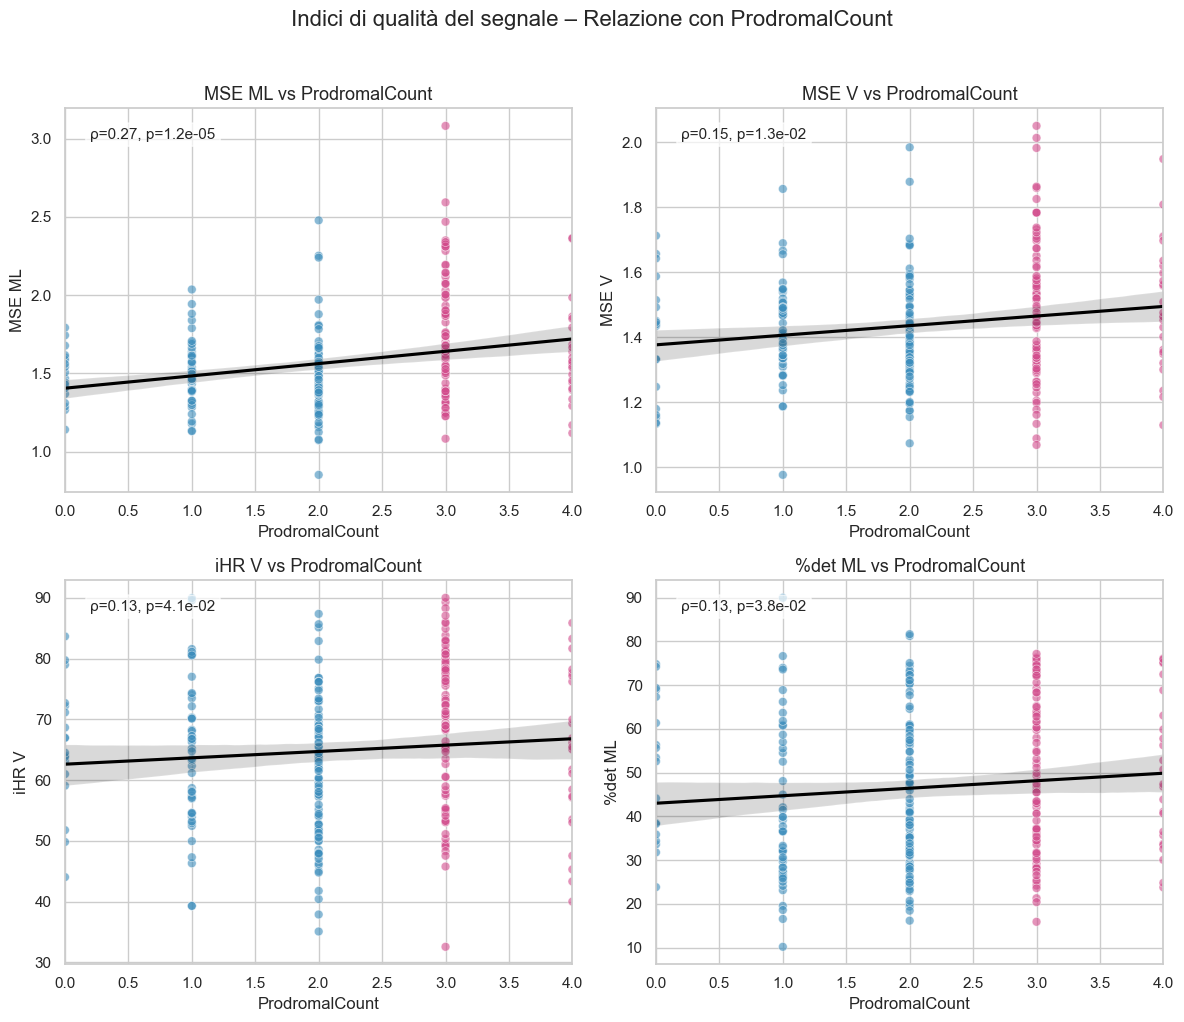

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import statsmodels.api as sm
import os

# 🔹 Caricamento dati
df = pd.read_excel("../data/raw/final_data_mondinoxicot.xlsx")
df.columns = df.columns.str.strip()

features = ["MSE V", "MSE ML", "MSE AP", "%det ML", "iHR V"]
covariates = ["Age", "H-Y", "Gait Speed"]

df[features + ["ProdromalCount"] + covariates] = df[features + ["ProdromalCount"] + covariates].apply(pd.to_numeric, errors="coerce")

results_spearman = []
for feat in features:
    rho, p = spearmanr(df["ProdromalCount"], df[feat], nan_policy="omit")
    results_spearman.append({"Feature": feat, "Spearman_rho": rho, "p_value": p})

spearman_df = pd.DataFrame(results_spearman).sort_values(by="Spearman_rho", ascending=False)
print("\n📊 Spearman correlation vs ProdromalCount")
print(spearman_df)

print("\n📊 Regressioni lineari parziali (Feature ~ ProdromalCount + Age + H-Y + GaitSpeed)")
for feat in features:
    df_temp = df.dropna(subset=[feat, "ProdromalCount"] + covariates)
    X = df_temp[["ProdromalCount"] + covariates]
    X = sm.add_constant(X)
    y = df_temp[feat]
    model = sm.OLS(y, X).fit()
    print(f"\n--- {feat} ---")
    print(model.summary().tables[1])  # solo la tabella coeff

key_features = ["MSE ML", "MSE V", "iHR V", "%det ML"]
palette = {0: "#3C8DBC", 1: "#D24C8C"}  # blu vs rosa

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, feat in enumerate(key_features):
    ax = axes[i]

    sns.scatterplot(
        data=df, x="ProdromalCount", y=feat, hue="target_bin",
        palette=palette, alpha=0.6, s=40, ax=ax, legend=False
    )

    sns.regplot(
        data=df, x="ProdromalCount", y=feat,
        scatter=False, color="black", ci=95, ax=ax
    )

    rho, p = spearmanr(df["ProdromalCount"], df[feat], nan_policy="omit")
    ax.text(0.05, 0.95, f"ρ={rho:.2f}, p={p:.1e}",
            transform=ax.transAxes, ha="left", va="top", fontsize=11,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

    ax.set_title(f"{feat} vs ProdromalCount", fontsize=13)
    ax.set_xlabel("ProdromalCount")
    ax.set_ylabel(feat)

fig.suptitle("Indici di qualità del segnale – Relazione con ProdromalCount", fontsize=16, y=1.02)
plt.tight_layout()
os.makedirs("../figurez/global", exist_ok=True)
plt.savefig("../figurez/global/key_signal_quality_vs_prodrome.png", dpi=400)
plt.show()

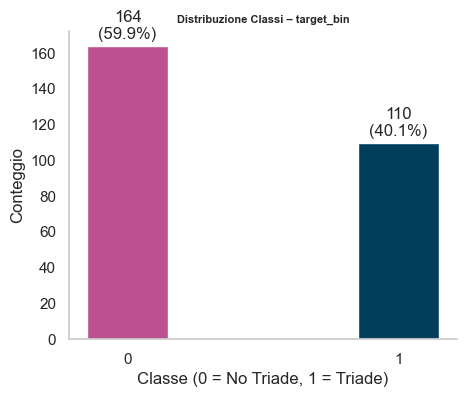

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

palette = {0: "#bc5090", 1: "#003f5c"}

counts = df['target_bin'].value_counts().sort_index()
percentages = 100 * counts / counts.sum()

plt.figure(figsize=(5, 4))
bar_width = 0.3
bars = plt.bar(
    counts.index.astype(str),
    counts.values,
    width=bar_width,
    color=[palette[i] for i in counts.index]
)

for i, bar in enumerate(bars):
    height = bar.get_height()
    label = f"{int(counts[i])}\n({percentages[i]:.1f}%)"
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        height + 2, 
        label,
        ha='center', va='bottom', fontsize=12
    )

plt.title("Distribuzione Classi – target_bin", fontsize=8, weight='bold')
plt.xlabel("Classe (0 = No Triade, 1 = Triade)", fontsize=12)
plt.ylabel("Conteggio", fontsize=12)

sns.despine()
plt.grid(False)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.savefig("../figurez/global/fig_target_bin_distribution.png", dpi=400, bbox_inches='tight')
plt.show()

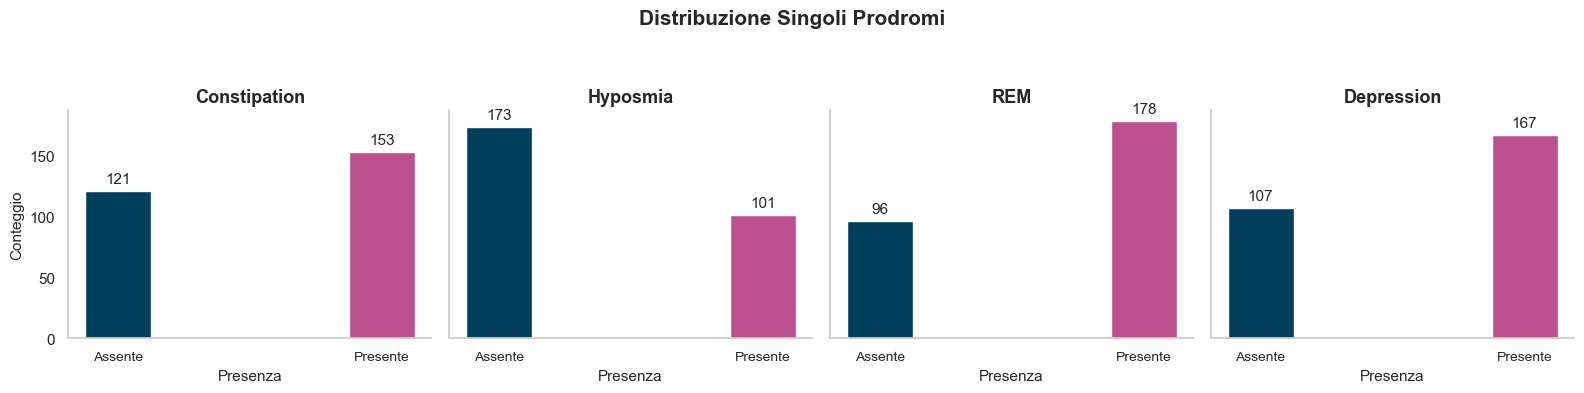

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

palette = {0: "#003f5c", 1: "#bc5090"}

prodromi = ['Constipation', 'Hyposmia', 'REM', 'Depression']
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)

bar_width = 0.25  # leggermente più larghe
bar_spacing = 0.005  # distanza minima tra barre

for i, col in enumerate(prodromi):
    ax = axes[i]
    counts = df[col].value_counts().sort_index()

   
    x = np.arange(len(counts))  # [0, 1]

    bars = ax.bar(
        x,
        counts.values,
        width=bar_width,
        color=[palette[int(k)] for k in counts.index]
    )

    
    ax.set_title(col, fontsize=13, weight='bold')
    ax.set_xlabel("Presenza", fontsize=11)
    ax.set_xticks(x)
    ax.set_xticklabels(["Assente", "Presente"], fontsize=10)

   
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            height + 4,
            f"{int(height)}",
            ha='center', va='bottom',
            fontsize=11
        )

    
    ax.grid(False)
    sns.despine(ax=ax)

axes[0].set_ylabel("Conteggio", fontsize=11)
plt.suptitle("Distribuzione Singoli Prodromi", fontsize=15, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig("../figurez/global/fig_prodromi_radarpalette_compact.png", dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from cliffs_delta import cliffs_delta
import warnings
import os

warnings.filterwarnings("ignore")

df = pd.read_excel("../data/raw/final_data_mondinoxicot.xlsx")
df.columns = df.columns.str.strip()

exclude_cols = ['target_bin', 'Constipation', 'Hyposmia', 'REM', 'Depression']
features = df.select_dtypes(include=[np.number]).columns.difference(exclude_cols)

os.makedirs("../output/statistical_tests", exist_ok=True)

results = []

for feat in features:
    group0 = df[df['target_bin'] == 0][feat].dropna()
    group1 = df[df['target_bin'] == 1][feat].dropna()
    
    # 🔹 Mann–Whitney U test
    stat, p = mannwhitneyu(group0, group1, alternative='two-sided')
  
    eff, strength = cliffs_delta(group1.tolist(), group0.tolist())
    dir_eff = "↑" if eff > 0 else "↓" if eff < 0 else "="
 
    mean_0, mean_1 = group0.mean(), group1.mean()
    median_0, median_1 = group0.median(), group1.median()

    
    if p < 0.001:
        sig_label = '***'
    elif p < 0.01:
        sig_label = '**'
    elif p < 0.05:
        sig_label = '*'
    else:
        sig_label = 'n.s.'

   
    results.append({
        'Feature': feat,
        'Mean_0': round(mean_0, 2),
        'Mean_1': round(mean_1, 2),
        'Median_0': round(median_0, 2),
        'Median_1': round(median_1, 2),
        'p_value': round(p, 4),
        'Significance': sig_label,
        'Cliffs_delta': round(eff, 3),
        'Effect_direction': dir_eff,
        'Effect_strength': strength.capitalize()
    })

df_results = pd.DataFrame(results)
df_results.sort_values("p_value", inplace=True)

df_results.to_csv("../tables/mannwhitney_cliffsdelta_summary.csv", index=False)

print(df_results.head(10))

             Feature  Mean_0  Mean_1  Median_0  Median_1  p_value  \
16            MSE ML    1.48    1.72      1.46      1.64   0.0000   
21    ProdromalCount    1.47    3.25      2.00      3.00   0.0000   
32             iHR V   62.74   68.10     63.37     69.43   0.0003   
17             MSE V    1.41    1.49      1.40      1.46   0.0024   
23    Sex (M=1, F=2)    1.04    1.24      1.00      1.00   0.0037   
29            Weigth  115.97  101.01     92.00     78.00   0.0045   
15            MSE AP    1.33    1.41      1.32      1.38   0.0048   
1            %det ML   44.74   49.71     40.85     47.37   0.0205   
4            Cadence  106.00  109.61    107.79    109.96   0.0317   
7   Duration (years)    7.90    8.93      6.00      7.00   0.0334   

   Significance  Cliffs_delta Effect_direction Effect_strength  
16          ***         0.412                ↑          Medium  
21          ***         1.000                ↑           Large  
32          ***         0.264                

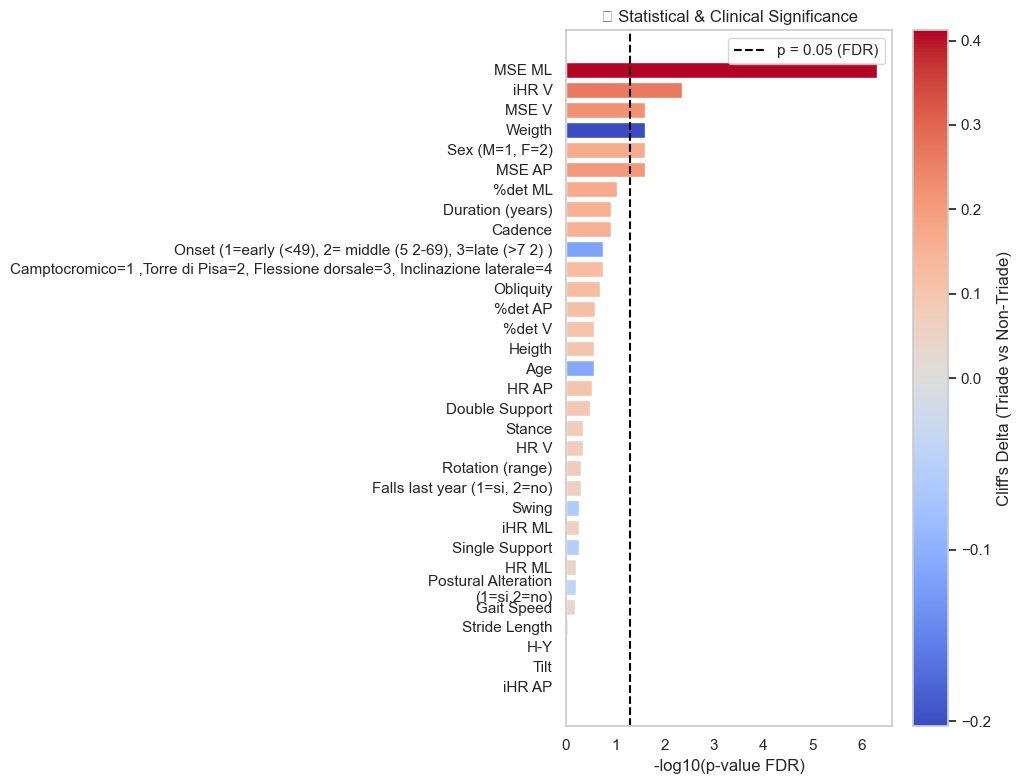


📊 Summary of Significance Categories:
Significance_Label
❌ Not Significant                           23
✅ Statistically & Clinically Significant     6
💡 Clinically Meaningful only                 3
Name: count, dtype: int64


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from cliffs_delta import cliffs_delta
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import warnings, os

warnings.filterwarnings("ignore")

df = pd.read_excel("../data/raw/final_data_mondinoxicot.xlsx")
df.columns = df.columns.str.strip()

df = df.apply(lambda s: pd.to_numeric(s, errors="ignore"))

exclude_cols = ['target_bin','Constipation','Hyposmia','REM','Depression','ID','ProdromalCount']
features = df.select_dtypes(include=[np.number]).columns.difference(exclude_cols)

os.makedirs("../tables/stats", exist_ok=True)

results = []
for feat in features:
    group0 = df[df['target_bin'] == 0][feat].dropna()
    group1 = df[df['target_bin'] == 1][feat].dropna()
    if len(group0) == 0 or len(group1) == 0:
        continue

    stat, p = mannwhitneyu(group0, group1, alternative='two-sided')
    eff, strength = cliffs_delta(group1.tolist(), group0.tolist())
    dir_eff = "↑" if eff > 0 else "↓" if eff < 0 else "="

    mean_0, mean_1 = group0.mean(), group1.mean()
    median_0, median_1 = group0.median(), group1.median()

    if p < 0.001: sig_label = '***'
    elif p < 0.01: sig_label = '**'
    elif p < 0.05: sig_label = '*'
    else: sig_label = 'n.s.'

    results.append({
        'Feature': feat,
        'Mean_0': round(mean_0, 2),
        'Mean_1': round(mean_1, 2),
        'Median_0': round(median_0, 2),
        'Median_1': round(median_1, 2),
        'p_value': p,
        'Significance': sig_label,
        'Cliffs_delta': round(eff, 3),
        'Effect_direction': dir_eff,
        'Effect_strength': strength.capitalize()
    })

df_results = pd.DataFrame(results)

reject, pvals_corrected, _, _ = multipletests(df_results['p_value'], alpha=0.05, method='fdr_bh')
df_results['p_value_corrected'] = pvals_corrected
df_results['Significant_FDR'] = reject

df_results.sort_values("p_value_corrected", inplace=True)
df_results.to_csv("../tables/mannwhitney_cliffsdelta_summary.csv", index=False)

fig, ax = plt.subplots(figsize=(10, 8))

vmin = df_results['Cliffs_delta'].min()
vmax = df_results['Cliffs_delta'].max()
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)
cmap = cm.coolwarm
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
bar_colors = cmap(norm(df_results['Cliffs_delta']))

bars = ax.barh(
    df_results['Feature'],
    -np.log10(df_results['p_value_corrected']),
    color=bar_colors
)

ax.axvline(-np.log10(0.05), color='black', linestyle='--', label='p = 0.05 (FDR)')
ax.set_xlabel("-log10(p-value FDR)")
ax.set_title("🔍 Statistical & Clinical Significance")
ax.set_facecolor('white')
fig.patch.set_facecolor('white')
ax.legend(loc='upper right')

ax.invert_yaxis()

cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Cliff's Delta (Triade vs Non-Triade)")

ax.grid(False)
fig.tight_layout()
plt.savefig("../figurez/global/barplot_significance_cliffsdelta.png", dpi=300)
plt.show()

def label_significance(row):
    statistically_significant = row['p_value_corrected'] < 0.05
    clinically_meaningful = abs(row['Cliffs_delta']) >= 0.147  # >= small
    if statistically_significant and clinically_meaningful:
        return '✅ Statistically & Clinically Significant'
    elif statistically_significant:
        return '🔬 Statistically Significant only'
    elif clinically_meaningful:
        return '💡 Clinically Meaningful only'
    else:
        return '❌ Not Significant'

df_results['Significance_Label'] = df_results.apply(label_significance, axis=1)
df_results.to_csv("../tables/mannwhitney_cliffsdelta_annotated.csv", index=False)

print("\n📊 Summary of Significance Categories:")
print(df_results['Significance_Label'].value_counts())

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from cliffs_delta import cliffs_delta
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
import os, warnings

warnings.filterwarnings("ignore")

df = pd.read_excel("../data/raw/final_data_mondinoxicot.xlsx")
df.columns = df.columns.str.strip()

df = df.apply(lambda s: pd.to_numeric(s, errors="ignore"))

col_age   = "Age"
col_sex   = "Sex (M=1, F=2)"
col_hy    = "H-Y"
col_speed = "Gait Speed"
col_h     = "Heigth"   
col_w     = "Weigth"   
col_pc    = "ProdromalCount"
col_target= "target_bin"

core_features = ["MSE V", "MSE ML", "MSE AP", "iHR V", "%det ML"]  # %det ML opzionale incluso

# Assicurati che le colonne esistano
missing = [c for c in core_features + [col_pc, col_age, col_sex, col_hy, col_speed, col_h, col_w, col_target] if c not in df.columns]
if missing:
    raise ValueError(f"Colonne mancanti nel dataset: {missing}")

h_vals = pd.to_numeric(df[col_h], errors="coerce")
is_cm = np.nanmedian(h_vals) > 3
height_m = h_vals / 100.0 if is_cm else h_vals
weight_kg = pd.to_numeric(df[col_w], errors="coerce")
bmi = weight_kg / (height_m ** 2)
df["BMI"] = bmi

covariates = [col_age, col_sex, "BMI", col_hy, col_speed]

def mean_sd(x):
    return f"{np.nanmean(x):.2f} ± {np.nanstd(x, ddof=1):.2f}"

def median_iqr(x):
    x = pd.Series(x).dropna()
    if x.empty:
        return "NA"
    q1, q3 = np.percentile(x, [25, 75])
    return f"{np.nanmedian(x):.2f} [{q1:.2f}-{q3:.2f}]"

def adjusted_beta(df_, ycol):
    """
    OLS: y ~ ProdromalCount + Age + Sex + BMI + H-Y + GaitSpeed
    Ritorna coeff, CI, p per ProdromalCount.
    """
    use_cols = [ycol, col_pc] + covariates
    d = df_[use_cols].apply(pd.to_numeric, errors="coerce").dropna()
    if d.shape[0] < 20:
        return np.nan, (np.nan, np.nan), np.nan  # troppo pochi dati
    X = sm.add_constant(d[[col_pc] + covariates])
    y = d[ycol]
    model = sm.OLS(y, X).fit()
    beta = model.params[col_pc]
    ci_low, ci_high = model.conf_int().loc[col_pc]
    pval = model.pvalues[col_pc]
    return beta, (ci_low, ci_high), pval

def mw_cliff(df_, feat):
    g0 = df_.loc[df_[col_target]==0, feat].dropna()
    g1 = df_.loc[df_[col_target]==1, feat].dropna()
    if len(g0)==0 or len(g1)==0:
        return np.nan, np.nan, np.nan, "NA"
    stat, p = mannwhitneyu(g0, g1, alternative="two-sided")
    eff, strength = cliffs_delta(g1.tolist(), g0.tolist())  # direzione: Triade vs Non-Triade
    return p, eff, strength.capitalize(), "↑" if eff>0 else "↓" if eff<0 else "="

rows = []
for feat in core_features:
   
    g0 = df.loc[df[col_target]==0, feat]
    g1 = df.loc[df[col_target]==1, feat]
    mean_sd_0 = mean_sd(g0)
    mean_sd_1 = mean_sd(g1)
    med_iqr_0 = median_iqr(g0)
    med_iqr_1 = median_iqr(g1)


    p_mw, delta, strength, direction = mw_cliff(df, feat)


    beta, (ci_l, ci_h), p_adj = adjusted_beta(df, feat)

    rows.append({
        "Feature": feat,
        "Mean±SD (Non-Triade)": mean_sd_0,
        "Mean±SD (Triade)": mean_sd_1,
        "Median [IQR] (Non-Triade)": med_iqr_0,
        "Median [IQR] (Triade)": med_iqr_1,
        "p_MannWhitney": p_mw,
        "Cliff_delta": delta,
        "Effect_strength": strength,
        "Effect_direction": direction,
        "Adj_beta(PC)": beta,
        "Adj_beta_CI95%": f"[{ci_l:.3f}, {ci_h:.3f}]" if pd.notna(ci_l) else "NA",
        "Adj_p(PC)": p_adj
    })

main_df = pd.DataFrame(rows)


rej_mw, p_mw_fdr, _, _ = multipletests(main_df["p_MannWhitney"], alpha=0.05, method="fdr_bh")
main_df["p_MW_FDR"] = p_mw_fdr
main_df["Significant_FDR"] = rej_mw


main_df.sort_values("p_MW_FDR", inplace=True)

sens_rows = []
for sex_val, sex_label in [(1, "Male"), (2, "Female")]:
    dsex = df[df[col_sex]==sex_val].copy()
    for feat in core_features:
        p_mw, delta, strength, direction = mw_cliff(dsex, feat)
        sens_rows.append({
            "Sex": sex_label,
            "Feature": feat,
            "p_MannWhitney": p_mw,
            "Cliff_delta": delta,
            "Effect_strength": strength,
            "Effect_direction": direction
        })
sens_df = pd.DataFrame(sens_rows)

out = []
for sex_label, sub in sens_df.groupby("Sex"):
    if sub["p_MannWhitney"].notna().sum() > 0:
        rej, p_fdr, _, _ = multipletests(sub["p_MannWhitney"].fillna(1.0), alpha=0.05, method="fdr_bh")
        sub = sub.copy()
        sub["p_FDR"] = p_fdr
        sub["Significant_FDR"] = rej
    out.append(sub)
sens_df = pd.concat(out, ignore_index=True)

os.makedirs("../tables", exist_ok=True)

paper_cols = [
    "Feature",
    "Mean±SD (Non-Triade)", "Mean±SD (Triade)",
    "Median [IQR] (Non-Triade)", "Median [IQR] (Triade)",
    "p_MannWhitney", "p_MW_FDR",
    "Cliff_delta", "Effect_strength", "Effect_direction",
    "Adj_beta(PC)", "Adj_beta_CI95%", "Adj_p(PC)"
]
paper_table = main_df[paper_cols].reset_index(drop=True)

paper_table.to_csv("../tables/core_features_vs_triade_table.csv", index=False)
sens_df.to_csv("../tables/sensitivity_by_sex.csv", index=False)

latex_table = paper_table.to_latex(index=False, escape=True, longtable=True, float_format="%.3g")
with open("../tables/core_features_vs_triade_table.tex", "w") as f:
    f.write(latex_table)

print("\n=== CORE FEATURES — Tabella (prime righe) ===")
print(paper_table.head(10))
print("\nFile salvati in ../tables/:")
print(" - core_features_vs_triade_table.csv")
print(" - core_features_vs_triade_table.tex")
print(" - sensitivity_by_sex.csv")


=== CORE FEATURES — Tabella (prime righe) ===
   Feature Mean±SD (Non-Triade) Mean±SD (Triade) Median [IQR] (Non-Triade)  \
0   MSE ML          1.48 ± 0.23      1.72 ± 0.36          1.46 [1.32-1.60]   
1    iHR V        62.74 ± 11.55    68.10 ± 12.64       63.37 [53.99-70.29]   
2    MSE V          1.41 ± 0.16      1.49 ± 0.21          1.40 [1.31-1.50]   
3   MSE AP          1.33 ± 0.18      1.41 ± 0.27          1.32 [1.23-1.41]   
4  %det ML        44.74 ± 17.30    49.71 ± 17.57       40.85 [31.13-58.17]   

  Median [IQR] (Triade)  p_MannWhitney      p_MW_FDR  Cliff_delta  \
0      1.64 [1.47-1.92]   1.564248e-08  7.821241e-08     0.411700   
1   69.43 [58.02-78.29]   2.829513e-04  7.073781e-04     0.263659   
2      1.46 [1.34-1.61]   2.364494e-03  3.940823e-03     0.221386   
3      1.38 [1.25-1.54]   4.763564e-03  5.954455e-03     0.205547   
4   47.37 [34.47-65.11]   2.049420e-02  2.049420e-02     0.167869   

  Effect_strength Effect_direction  Adj_beta(PC)   Adj_beta_CI95%  \


In [ ]:
import pandas as pd
import numpy as np

df = pd.read_excel("../data/raw/final_data_mondinoxicot.xlsx")
df.columns = df.columns.str.strip()

exclude_cols = ['target_bin', 'Constipation', 'Hyposmia', 'REM', 'Depression', 'ID', 'ProdromalCount']
features = df.select_dtypes(include=[np.number]).columns.difference(exclude_cols)

print("\n📋 Lista feature numeriche candidate all'ANCOVA:\n")
for feat in sorted(features):
    print(f"- {feat}")


📋 Lista feature numeriche candidate all'ANCOVA:

- %det AP
- %det ML
- %det V
- Age
- Cadence
- Camptocromico=1 ,Torre di Pisa=2, Flessione dorsale=3, Inclinazione laterale=4
- Double Support
- Duration (years)
- Falls last year (1=si, 2=no)
- Gait Speed
- H-Y
- HR AP
- HR ML
- HR V
- Heigth
- MSE AP
- MSE ML
- MSE V
- Obliquity
- Onset (1=early (<49), 2= middle (5 2-69), 3=late (>7 2) )
- Postural Alteration
(1=si,2=no)
- Rotation (range)
- Sex (M=1, F=2)
- Single Support
- Stance
- Stride Length
- Swing
- Tilt
- Weigth
- iHR AP
- iHR ML
- iHR V


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings, os
warnings.filterwarnings("ignore")

df = pd.read_excel("../data/raw/final_data_mondinoxicot.xlsx")
df.columns = df.columns.str.strip()

rename_map = {
    'Sex (M=1, F=2)': 'Sex',
    'H-Y': 'HY',
    'Gait Speed': 'GaitSpeed',
    'Stride Length': 'StrideLength',
    'Double Support': 'DoubleSupport',
    'Single Support': 'SingleSupport',
    'Rotation (range)': 'RotationRange',
    'Postural Alteration\n(1=si,2=no)': 'PosturalAlteration',
    'Falls last year (1=si, 2=no)': 'FallsLastYear',
    'Onset (1=early (<49), 2= middle (5 2-69), 3=late (>7 2) )': 'OnsetCategory',
    'Heigth': 'Height',
    'Weigth': 'Weight',
    '%det ML': 'detML',
    '%det V': 'detV',
    '%det AP': 'detAP',
    'MSE ML': 'MSE_ML',
    'MSE V': 'MSE_V',
    'MSE AP': 'MSE_AP',
    'HR V': 'HR_V',
    'HR ML': 'HR_ML',
    'HR AP': 'HR_AP',
    'iHR V': 'iHR_V',
    'iHR ML': 'iHR_ML',
    'iHR AP': 'iHR_AP'
}
df = df.rename(columns=rename_map)

h = pd.to_numeric(df.get('Height'), errors='coerce')
w = pd.to_numeric(df.get('Weight'), errors='coerce')
# euristica cm vs m
is_cm = np.nanmedian(h) > 3 if h.notna().any() else True
height_m = h / 100.0 if is_cm else h
df['BMI'] = w / (height_m ** 2)

features_for_ancova = ['MSE_ML', 'MSE_V', 'MSE_AP', 'iHR_V', 'detML']

covariates = ['Age', 'Sex', 'BMI', 'HY', 'GaitSpeed']

for col in features_for_ancova + ['target_bin'] + covariates:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

results = []
for feat in features_for_ancova:
    if feat not in df.columns:
        print(f"❗Feature {feat} non trovata nel DataFrame!")
        continue
   
    use_cols = [feat, 'target_bin'] + covariates
    d = df[use_cols].dropna()
    if d.shape[0] < 20:
        print(f"⚠️ Pochi dati per {feat} (n={d.shape[0]}), salto.")
        continue

    formula = f"{feat} ~ C(target_bin) + Age + C(Sex) + BMI + HY + GaitSpeed"
    try:
        model = ols(formula, data=d).fit()
        table = sm.stats.anova_lm(model, typ=2)  # Type II

        # estrai p-values dei termini
        p_triade    = table.loc['C(target_bin)', 'PR(>F)'] if 'C(target_bin)' in table.index else np.nan
        p_age       = table.loc['Age', 'PR(>F)']           if 'Age' in table.index else np.nan
        p_sex       = table.loc['C(Sex)', 'PR(>F)']        if 'C(Sex)' in table.index else np.nan
        p_bmi       = table.loc['BMI', 'PR(>F)']           if 'BMI' in table.index else np.nan
        p_hy        = table.loc['HY', 'PR(>F)']            if 'HY' in table.index else np.nan
        p_speed     = table.loc['GaitSpeed', 'PR(>F)']     if 'GaitSpeed' in table.index else np.nan

        results.append({
            'Feature': feat,
            'n_used': d.shape[0],
            'p_target_bin': p_triade,
            'p_Age': p_age,
            'p_Sex': p_sex,
            'p_BMI': p_bmi,
            'p_HY': p_hy,
            'p_GaitSpeed': p_speed,
            'Effect_persists_after_adjust?': '✅ Yes' if (pd.notna(p_triade) and p_triade < 0.05) else '❌ No'
        })
    except Exception as e:
        print(f"❗Errore su {feat}: {e}")

df_ancova = pd.DataFrame(results)
df_ancova = df_ancova.sort_values('p_target_bin', na_position='last')

os.makedirs("../tables", exist_ok=True)
df_ancova.to_csv("../tables/ancova_core_features_adjusted.csv", index=False)

print("\n📊 Risultati ANCOVA (aggiustato per Age, Sex, BMI, HY, GaitSpeed):\n")
print(df_ancova.to_string(index=False))


📊 Risultati ANCOVA (aggiustato per Age, Sex, BMI, HY, GaitSpeed):

Feature  n_used  p_target_bin    p_Age    p_Sex    p_BMI     p_HY  p_GaitSpeed Effect_persists_after_adjust?
 MSE_ML     251  1.189306e-11 0.555003 0.005446 0.418765 0.221040 9.517514e-01                         ✅ Yes
  iHR_V     253  3.358535e-05 0.188864 0.014889 0.026911 0.000496 2.911610e-08                         ✅ Yes
  MSE_V     251  2.135434e-04 0.499362 0.094861 0.289172 0.561243 7.441568e-01                         ✅ Yes
 MSE_AP     251  5.541382e-04 0.525279 0.000186 0.013162 0.097375 8.047082e-01                         ✅ Yes
  detML     255  3.717252e-02 0.843058 0.073793 0.809515 0.011019 1.078349e-02                         ✅ Yes


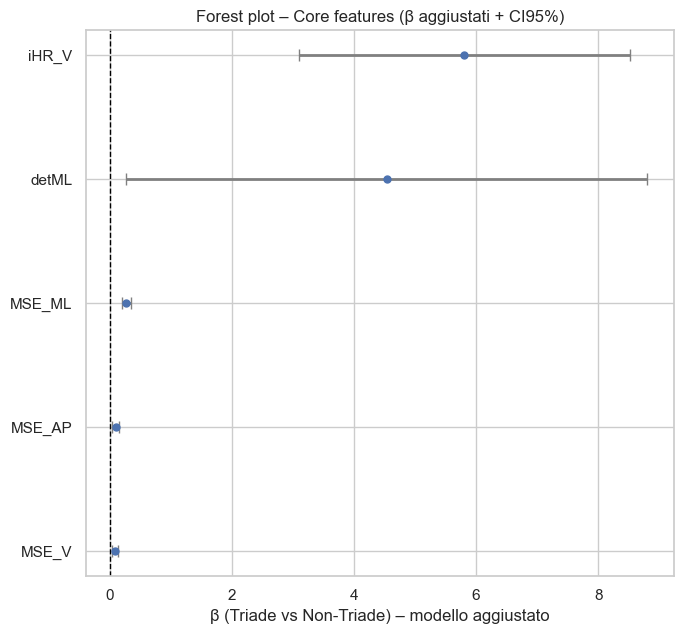

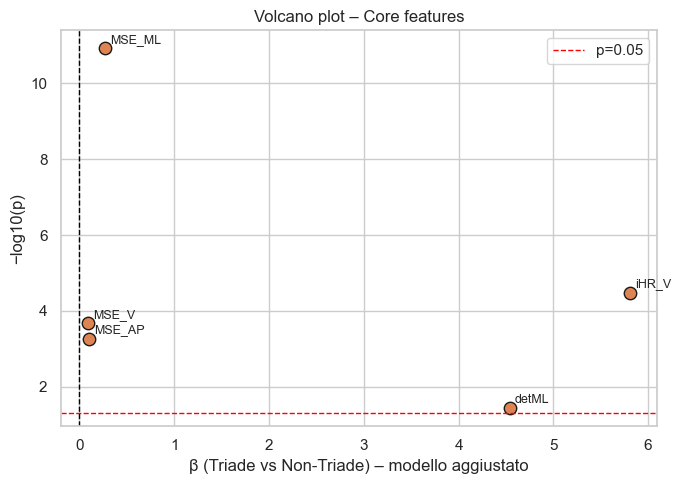


✅ Salvati:
 - ../output/models/adjusted_betas_core.csv
 - ../output/models/interaction_sex_target.csv
 - ../output/models/stratified_by_sex.csv
 - ../output/models/summary_final_core.csv
 - ../figures/forest_core_beta_adjusted.png
 - ../figures/volcano_core_beta_adjusted.png


In [ ]:
import pandas as pd
import numpy as np
import os, warnings
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

df = pd.read_excel("../data/raw/final_data_mondinoxicot.xlsx")
df.columns = df.columns.str.strip()

rename_map = {
    'Sex (M=1, F=2)': 'Sex',
    'H-Y': 'HY',
    'Gait Speed': 'GaitSpeed',
    'Stride Length': 'StrideLength',
    'Double Support': 'DoubleSupport',
    'Single Support': 'SingleSupport',
    'Rotation (range)': 'RotationRange',
    'Postural Alteration\n(1=si,2=no)': 'PosturalAlteration',
    'Falls last year (1=si, 2=no)': 'FallsLastYear',
    'Onset (1=early (<49), 2= middle (5 2-69), 3=late (>7 2) )': 'OnsetCategory',
    'Heigth': 'Height',
    'Weigth': 'Weight',
    '%det ML': 'detML',
    '%det V': 'detV',
    '%det AP': 'detAP',
    'MSE ML': 'MSE_ML',
    'MSE V': 'MSE_V',
    'MSE AP': 'MSE_AP',
    'HR V': 'HR_V',
    'HR ML': 'HR_ML',
    'HR AP': 'HR_AP',
    'iHR V': 'iHR_V',
    'iHR ML': 'iHR_ML',
    'iHR AP': 'iHR_AP'
}
df = df.rename(columns=rename_map)

h = pd.to_numeric(df.get('Height'), errors='coerce')
w = pd.to_numeric(df.get('Weight'), errors='coerce')
is_cm = np.nanmedian(h) > 3 if h.notna().any() else True
height_m = h/100.0 if is_cm else h
df['BMI'] = w / (height_m**2)

core_features = ['MSE_ML', 'MSE_V', 'MSE_AP', 'iHR_V', 'detML']
covariates    = ['Age', 'Sex', 'BMI', 'HY', 'GaitSpeed']

for col in core_features + covariates + ['target_bin']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Output dirs
os.makedirs("../tables", exist_ok=True)
os.makedirs("../figurez/global", exist_ok=True)

main_rows = []
for feat in core_features:
    use_cols = [feat, 'target_bin'] + covariates
    d = df[use_cols].dropna()
    if d.shape[0] < 25:
        continue
   
    formula = f"{feat} ~ C(target_bin) + Age + C(Sex) + BMI + HY + GaitSpeed"
    m = ols(formula, data=d).fit()

    term = 'C(target_bin)[T.1]'
    if term in m.params.index:
        beta = m.params[term]
        ci_l, ci_h = m.conf_int().loc[term]
        pval = m.pvalues[term]
    else:
        beta, ci_l, ci_h, pval = [np.nan]*4

    main_rows.append({
        'Feature': feat,
        'n_used': d.shape[0],
        'beta_target': beta,
        'CI95_low': ci_l,
        'CI95_high': ci_h,
        'p_target': pval
    })

df_main = pd.DataFrame(main_rows).sort_values('p_target')
df_main.to_csv("../tables/adjusted_betas_core.csv", index=False)

if not df_main.empty:
    plot_df = df_main.copy()
    plot_df = plot_df.sort_values('beta_target')  # ordine per beta

    fig, ax = plt.subplots(figsize=(7, 4 + 0.5*len(plot_df)))
    y = np.arange(len(plot_df))
    ax.errorbar(
        x=plot_df['beta_target'],
        y=y,
        xerr=[plot_df['beta_target'] - plot_df['CI95_low'], plot_df['CI95_high'] - plot_df['beta_target']],
        fmt='o', ecolor='gray', capsize=4, elinewidth=2, markersize=5
    )
    ax.axvline(0, color='black', linestyle='--', linewidth=1)
    ax.set_yticks(y)
    ax.set_yticklabels(plot_df['Feature'])
    ax.set_xlabel("β (Triade vs Non-Triade) – modello aggiustato")
    ax.set_title("Forest plot – Core features (β aggiustati + CI95%)")
    plt.tight_layout()
    plt.savefig("../figurez/global/forest_core_beta_adjusted.png", dpi=400)
    plt.show()

if not df_main.empty:
    vdf = df_main.copy()
    vdf['neglog10p'] = -np.log10(vdf['p_target'])
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.scatter(vdf['beta_target'], vdf['neglog10p'], s=60)

    sig = vdf['p_target'] < 0.05
    ax.scatter(vdf.loc[sig, 'beta_target'], vdf.loc[sig, 'neglog10p'], s=80, edgecolor='k')

   
    for _, r in vdf.iterrows():
        ax.annotate(r['Feature'], (r['beta_target'], r['neglog10p']), xytext=(4, 4),
                    textcoords='offset points', fontsize=9)

    ax.axhline(-np.log10(0.05), color='red', linestyle='--', linewidth=1, label='p=0.05')
    ax.axvline(0, color='black', linestyle='--', linewidth=1)
    ax.set_xlabel("β (Triade vs Non-Triade) – modello aggiustato")
    ax.set_ylabel("−log10(p)")
    ax.set_title("Volcano plot – Core features")
    ax.legend()
    plt.tight_layout()
    plt.savefig("../figurez/global/volcano_core_beta_adjusted.png", dpi=400)
    plt.show()

int_rows = []
for feat in core_features:
    use_cols = [feat, 'target_bin'] + covariates
    d = df[use_cols].dropna()
    if d.shape[0] < 25:
        continue

    formula = f"{feat} ~ C(target_bin)*C(Sex) + Age + BMI + HY + GaitSpeed"
    m = ols(formula, data=d).fit()

    main_term = 'C(target_bin)[T.1]'
    inter_term = 'C(target_bin)[T.1]:C(Sex)[T.2]'  # differenziale Triade nell'altro sesso (Sex=2 vs 1)

    def safe_extract(term):
        if term in m.params.index:
            b = m.params[term]
            l, h = m.conf_int().loc[term]
            p = m.pvalues[term]
            return b, l, h, p
        return np.nan, np.nan, np.nan, np.nan

    b_main, l_main, h_main, p_main = safe_extract(main_term)
    b_int,  l_int,  h_int,  p_int  = safe_extract(inter_term)

    int_rows.append({
        'Feature': feat,
        'n_used': d.shape[0],
        'beta_target_main_sex1': b_main,
        'CI95_low_main': l_main,
        'CI95_high_main': h_main,
        'p_main': p_main,
        'beta_interaction(Sex2_vs_Sex1)': b_int,
        'CI95_low_int': l_int,
        'CI95_high_int': h_int,
        'p_interaction': p_int
    })

df_inter = pd.DataFrame(int_rows).sort_values('p_interaction')
df_inter.to_csv("../tables/interaction_sex_target.csv", index=False)

strat_rows = []
for sex_val, sex_name in [(1, "Male"), (2, "Female")]:
    d_sex = df[df['Sex'] == sex_val].copy()
    for feat in core_features:
        use_cols = [feat, 'target_bin'] + ['Age', 'BMI', 'HY', 'GaitSpeed']
        d = d_sex[use_cols].dropna()
        if d.shape[0] < 20:
            continue
        formula = f"{feat} ~ C(target_bin) + Age + BMI + HY + GaitSpeed"
        m = ols(formula, data=d).fit()
        term = 'C(target_bin)[T.1]'
        if term in m.params.index:
            b = m.params[term]
            l, h = m.conf_int().loc[term]
            p = m.pvalues[term]
        else:
            b, l, h, p = [np.nan]*4

        strat_rows.append({
            'Sex': sex_name,
            'Feature': feat,
            'n_used': d.shape[0],
            'beta_target': b,
            'CI95_low': l,
            'CI95_high': h,
            'p_target': p
        })

df_strat = pd.DataFrame(strat_rows).sort_values(['Sex','p_target'])
df_strat.to_csv("../tables/stratified_by_sex.csv", index=False)


summary = df_main.merge(
    df_inter[['Feature','p_interaction']],
    on='Feature', how='left'
)

summary['sig_main_p<0.05'] = summary['p_target'] < 0.05
summary['sig_interaction_p<0.05'] = summary['p_interaction'] < 0.05

summary.to_csv("../tables/summary_final_core.csv", index=False)

print("\n✅ Salvati:")
print(" - ../tables/adjusted_betas_core.csv")
print(" - ../tables/interaction_sex_target.csv")
print(" - ../tables/stratified_by_sex.csv")
print(" - ../tables/summary_final_core.csv")
print(" - ../figurez/global/forest_core_beta_adjusted.png")
print(" - ../figurez/global/volcano_core_beta_adjusted.png")

In [ ]:
import pandas as pd
import numpy as np
import os, warnings
import statsmodels.api as sm
from statsmodels.formula.api import ols
from cliffs_delta import cliffs_delta
from statsmodels.stats.multitest import multipletests
warnings.filterwarnings("ignore")

df = pd.read_excel("../data/raw/final_data_mondinoxicot.xlsx")
df.columns = df.columns.str.strip()

rename_map = {
    'Sex (M=1, F=2)': 'Sex',
    'H-Y': 'HY',
    'Gait Speed': 'GaitSpeed',
    'Heigth': 'Height',
    'Weigth': 'Weight',
    '%det ML': 'detML',
    '%det V': 'detV',
    '%det AP': 'detAP',
    'MSE ML': 'MSE_ML',
    'MSE V': 'MSE_V',
    'MSE AP': 'MSE_AP',
    'iHR V': 'iHR_V',
}
df = df.rename(columns=rename_map)

h = pd.to_numeric(df.get('Height'), errors='coerce')
w = pd.to_numeric(df.get('Weight'), errors='coerce')
is_cm = np.nanmedian(h) > 3 if h.notna().any() else True
df['BMI'] = w / ((h/100.0 if is_cm else h)**2)

core_features = ['MSE_ML', 'MSE_V', 'MSE_AP', 'iHR_V', 'detML']
covariates    = ['Age', 'Sex', 'BMI', 'HY', 'GaitSpeed']

for col in core_features + covariates + ['target_bin']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

def adjusted_beta(d, ycol):
    """OLS: y ~ C(target_bin) + Age + C(Sex) + BMI + HY + GaitSpeed.
       Ritorna beta, CI, p per C(target_bin)[T.1]."""
    use_cols = [ycol, 'target_bin'] + covariates
    d = d[use_cols].dropna()
    if d.shape[0] < 25:
        return np.nan, np.nan, np.nan, np.nan, d.shape[0]
    m = ols(f"{ycol} ~ C(target_bin) + Age + C(Sex) + BMI + HY + GaitSpeed", data=d).fit()
    term = 'C(target_bin)[T.1]'
    if term in m.params.index:
        beta = m.params[term]
        ci_low, ci_high = m.conf_int().loc[term]
        pval = m.pvalues[term]
        return beta, ci_low, ci_high, pval, d.shape[0]
    return np.nan, np.nan, np.nan, np.nan, d.shape[0]

def effect_size(df_, feat):
    g0 = df_.loc[df_['target_bin']==0, feat].dropna()
    g1 = df_.loc[df_['target_bin']==1, feat].dropna()
    if len(g0)==0 or len(g1)==0:
        return np.nan, "NA", "="
    d, strength = cliffs_delta(g1.tolist(), g0.tolist())  # Triade vs Non
    direction = "↑" if d>0 else "↓" if d<0 else "="
    return d, strength.capitalize(), direction

def interaction_p(df_, feat):
    use_cols = [feat, 'target_bin'] + covariates
    d = df_[use_cols].dropna()
    if d.shape[0] < 30:
        return np.nan
    m = ols(f"{feat} ~ C(target_bin)*C(Sex) + Age + BMI + HY + GaitSpeed", data=d).fit()
    term = 'C(target_bin)[T.1]:C(Sex)[T.2]'
    return m.pvalues.get(term, np.nan)

rows = []
for feat in core_features:
    beta, ci_l, ci_h, p, n_used = adjusted_beta(df, feat)
    delta, strength, direction = effect_size(df, feat)
    p_int = interaction_p(df, feat)
    rows.append({
        "Feature": feat,
        "n_used": n_used,
        "Beta_adj": beta,
        "CI95%": f"[{ci_l:.3f}, {ci_h:.3f}]" if pd.notna(ci_l) else "NA",
        "p_adj": p,
        "Cliff_delta": delta,
        "Cliff_strength": strength,
        "Cliff_direction": direction,
        "p_interaction_SexxTriade": p_int
    })

tab = pd.DataFrame(rows)

rej, p_fdr, _, _ = multipletests(tab['p_adj'].fillna(1.0), alpha=0.05, method='fdr_bh')
tab['p_adj_FDR'] = p_fdr
tab['sig_adj_FDR'] = rej

tab['Sex×Triade (p<0.05)'] = tab['p_interaction_SexxTriade'] < 0.05

tab = tab.sort_values('p_adj_FDR')

os.makedirs("../tables", exist_ok=True)
tab.to_csv("../tables/final_core_table_beta_cliff_interaction.csv", index=False)

latex = tab.rename(columns={
    "n_used":"n",
    "Beta_adj":"$\\beta$ adj.",
    "CI95%":"CI 95\\%",
    "p_adj":"p (adj.)",
    "p_adj_FDR":"p FDR",
    "Cliff_delta":"Cliff's $\\delta$",
    "Cliff_strength":"Strength",
    "Cliff_direction":"Dir.",
    "p_interaction_SexxTriade":"p (Sex×Triade)",
    "Sex×Triade (p<0.05)":"Sex×Triade <0.05"
}).to_latex(index=False, escape=True, longtable=True, float_format="%.3g")
with open("../tables/final_core_table_beta_cliff_interaction.tex","w") as f:
    f.write(latex)

print("✅ Salvato:")
print(" - ../tables/final_core_table_beta_cliff_interaction.csv")
print(" - ../tables/final_core_table_beta_cliff_interaction.tex")
print("\nAnteprima:")
print(tab.head(10).to_string(index=False))

✅ Salvato:
 - ../output/tables/final_core_table_beta_cliff_interaction.csv
 - ../output/tables/final_core_table_beta_cliff_interaction.tex

Anteprima:
Feature  n_used  Beta_adj          CI95%        p_adj  Cliff_delta Cliff_strength Cliff_direction  p_interaction_SexxTriade    p_adj_FDR  sig_adj_FDR  Sex×Triade (p<0.05)
 MSE_ML     251  0.269630 [0.195, 0.344] 1.189306e-11     0.411700         Medium               ↑                  0.045813 5.946531e-11         True                 True
  iHR_V     253  5.806417 [3.100, 8.513] 3.358535e-05     0.263659          Small               ↑                  0.426651 8.396337e-05         True                False
  MSE_V     251  0.088314 [0.042, 0.135] 2.135434e-04     0.221386          Small               ↑                  0.149204 3.559056e-04         True                False
 MSE_AP     251  0.098100 [0.043, 0.153] 5.541382e-04     0.205547          Small               ↑                  0.913925 6.926727e-04         True                

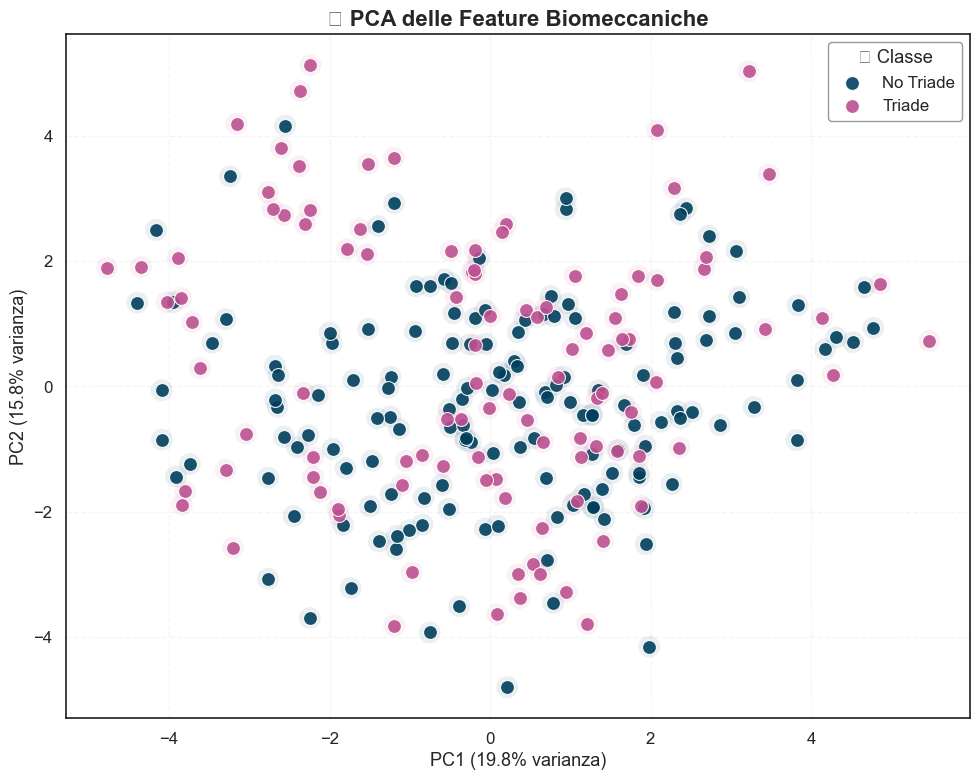

✅ PCA eseguita su 257 soggetti e 22 feature biomeccaniche.
   Varianza spiegata: PC1=19.8%, PC2=15.8%


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os

df = pd.read_excel("../data/raw/final_data_mondinoxicot.xlsx")
df.columns = df.columns.str.strip()

rename_map = {
    'Gait Speed': 'GaitSpeed',
    'Stride Length': 'StrideLength',
    'Double Support': 'DoubleSupport',
    'Single Support': 'SingleSupport',
    'Rotation (range)': 'RotationRange',
    '%det V': 'detV',
    '%det ML': 'detML',
    '%det AP': 'detAP',
    'MSE V': 'MSE_V',
    'MSE ML': 'MSE_ML',
    'MSE AP': 'MSE_AP',
    'HR V': 'HR_V',
    'HR ML': 'HR_ML',
    'HR AP': 'HR_AP',
    'iHR V': 'iHR_V',
    'iHR ML': 'iHR_ML',
    'iHR AP': 'iHR_AP'
}
df = df.rename(columns=rename_map)

biomech_cols = [
    'HR_V','HR_ML','HR_AP',
    'iHR_V','iHR_ML','iHR_AP',
    'detV','detML','detAP',
    'MSE_V','MSE_ML','MSE_AP',
    'Tilt','Obliquity','RotationRange',
    'Stance','Swing','DoubleSupport','SingleSupport',
    'StrideLength','Cadence','GaitSpeed'
]

biomech_cols_avail = [c for c in biomech_cols if c in df.columns]

y = pd.to_numeric(df['target_bin'], errors='coerce')

X = df[biomech_cols_avail].apply(pd.to_numeric, errors='coerce')

valid_mask = X.notna().all(axis=1) & y.notna()
X = X.loc[valid_mask]
y = y.loc[valid_mask].astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

palette = {0: "#003f5c", 1: "#bc5090"}

os.makedirs("../figurez/global", exist_ok=True)
plt.figure(figsize=(10, 8))
sns.set(style="white", font_scale=1.1)

for label, color in palette.items():
    mask = (y.values == label)
    plt.scatter(
        X_pca[mask, 0], X_pca[mask, 1],
        c=color, s=250, alpha=0.08, edgecolor='none'
    )
    plt.scatter(
        X_pca[mask, 0], X_pca[mask, 1],
        c=color, s=100, alpha=0.9, edgecolor='white', linewidth=0.8,
        label="Triade" if label == 1 else "No Triade"
    )

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% varianza)", fontsize=13)
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% varianza)", fontsize=13)
plt.title("✨ PCA delle Feature Biomeccaniche", fontsize=16, weight="bold")

plt.grid(True, linestyle='--', alpha=0.2)
plt.gca().set_facecolor('white')
plt.legend(title="🩺 Classe", loc="upper right", frameon=True, facecolor="white", edgecolor="gray")

plt.tight_layout()
plt.savefig("../figurez/global/pca_biomechanics.png", dpi=400)
plt.show()

print(f"✅ PCA eseguita su {X.shape[0]} soggetti e {X.shape[1]} feature biomeccaniche.")
print(f"   Varianza spiegata: PC1={pca.explained_variance_ratio_[0]*100:.1f}%, PC2={pca.explained_variance_ratio_[1]*100:.1f}%")

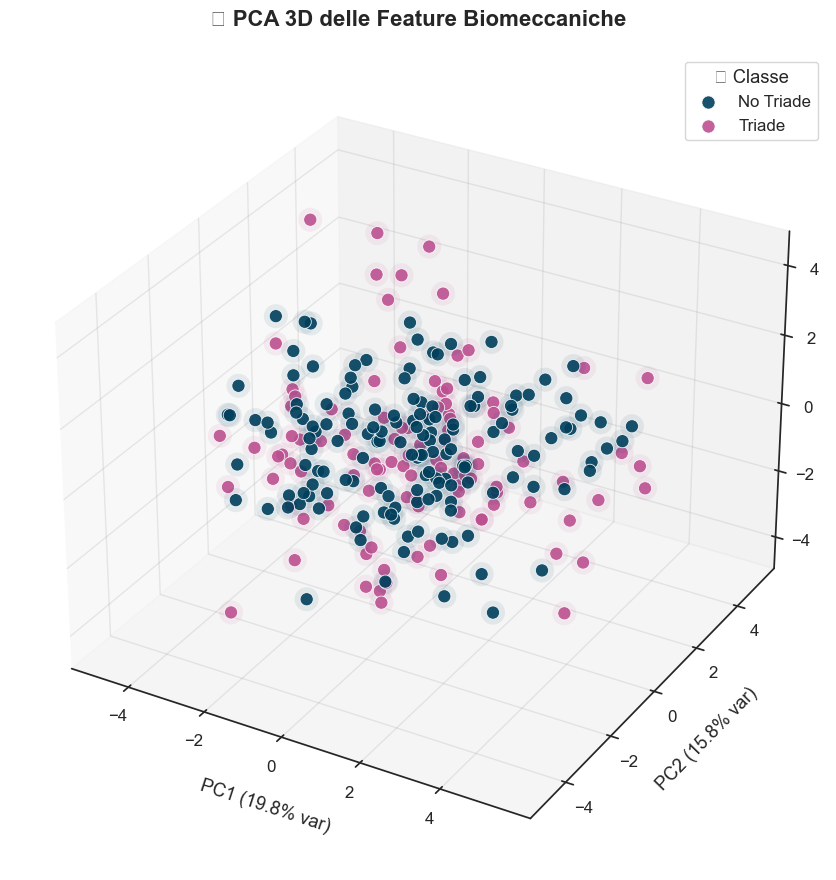

✅ PCA 3D su 257 soggetti e 22 feature.
   Varianza spiegata: PC1=19.8%, PC2=15.8%, PC3=10.6%


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (necessario per il 3D)
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os

df = pd.read_excel("../data/raw/final_data_mondinoxicot.xlsx")
df.columns = df.columns.str.strip()

rename_map = {
    'Gait Speed': 'GaitSpeed',
    'Stride Length': 'StrideLength',
    'Double Support': 'DoubleSupport',
    'Single Support': 'SingleSupport',
    'Rotation (range)': 'RotationRange',
    '%det V': 'detV',
    '%det ML': 'detML',
    '%det AP': 'detAP',
    'MSE V': 'MSE_V',
    'MSE ML': 'MSE_ML',
    'MSE AP': 'MSE_AP',
    'HR V': 'HR_V',
    'HR ML': 'HR_ML',
    'HR AP': 'HR_AP',
    'iHR V': 'iHR_V',
    'iHR ML': 'iHR_ML',
    'iHR AP': 'iHR_AP'
}
df = df.rename(columns=rename_map)

biomech_cols = [
    'HR_V','HR_ML','HR_AP',
    'iHR_V','iHR_ML','iHR_AP',
    'detV','detML','detAP',
    'MSE_V','MSE_ML','MSE_AP',
    'Tilt','Obliquity','RotationRange',
    'Stance','Swing','DoubleSupport','SingleSupport',
    'StrideLength','Cadence','GaitSpeed'
]
biomech_cols = [c for c in biomech_cols if c in df.columns]

X = df[biomech_cols].apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(df['target_bin'], errors='coerce')

mask = X.notna().all(axis=1) & y.notna()
X = X.loc[mask]
y = y.loc[mask].astype(int)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

palette = {0: "#003f5c", 1: "#bc5090"}   # 0 = No Triade (blu), 1 = Triade (rosa)
labels  = {0: "No Triade", 1: "Triade"}

os.makedirs("../figurez/global", exist_ok=True)
sns.set(style="white", font_scale=1.1)

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

for label, color in palette.items():
    m = (y.values == label)
    ax.scatter(
        X_pca[m, 0], X_pca[m, 1], X_pca[m, 2],
        c=color, s=300, alpha=0.08, edgecolor='none'
    )
    ax.scatter(
        X_pca[m, 0], X_pca[m, 1], X_pca[m, 2],
        c=color, s=90, alpha=0.9, edgecolor='white', linewidth=0.6,
        label=labels[label]
    )

ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)", labelpad=12)
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)", labelpad=12)
ax.set_zlabel(f"PC3 ({pca.explained_variance_ratio_[2]*100:.1f}% var)", labelpad=12)
ax.set_title("🌌 PCA 3D delle Feature Biomeccaniche", fontsize=16, weight="bold", pad=20)

ax.set_facecolor('white')
for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    axis._axinfo["grid"]['color'] = (0.6, 0.6, 0.6, 0.2)

ax.legend(title="🩺 Classe", loc='upper right', frameon=True)

plt.tight_layout()
plt.savefig("../figurez/global/pca_biomechanics_3d.png", dpi=400)
plt.show()

print(f"✅ PCA 3D su {X.shape[0]} soggetti e {X.shape[1]} feature.")
print(f"   Varianza spiegata: PC1={pca.explained_variance_ratio_[0]*100:.1f}%, "
      f"PC2={pca.explained_variance_ratio_[1]*100:.1f}%, "
      f"PC3={pca.explained_variance_ratio_[2]*100:.1f}%")

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from matplotlib import animation
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

var_pct = pca.explained_variance_ratio_ * 100
var_tot = var_pct[:3].sum()

palette = {0: "#003f5c", 1: "#bc5090"}   # 0 = No Triade (blu), 1 = Triade (rosa)
labels  = {0: "No Triade", 1: "Triade"}

sns.set(style="white", font_scale=1.1)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

def draw_points():
    for label, color in palette.items():
        mask = (y == label)
        # Layer "glow" tenue
        ax.scatter(
            X_pca[mask, 0], X_pca[mask, 1], X_pca[mask, 2],
            c=color, s=260, alpha=0.07, edgecolor='none'
        )
        # Marker principale (contorno nero per proiettori)
        ax.scatter(
            X_pca[mask, 0], X_pca[mask, 1], X_pca[mask, 2],
            c=color, s=90, alpha=0.95, edgecolor='black', linewidth=0.4,
            label=labels[label]
        )

def update(angle):
    ax.cla()
    draw_points()
    ax.set_xlabel(f"PC1 ({var_pct[0]:.1f}%)", labelpad=10)
    ax.set_ylabel(f"PC2 ({var_pct[1]:.1f}%)", labelpad=10)
    ax.set_zlabel(f"PC3 ({var_pct[2]:.1f}%)", labelpad=10)
    ax.set_title(f"PCA 3D: nessuna separazione visibile\n(~{var_tot:.1f}% della varianza totale)", 
                 fontsize=14, weight='bold', pad=18)
    ax.legend(title="Classe", loc="upper right", frameon=True, facecolor="white", edgecolor="gray")
    # Sfondo bianco + griglia leggera
    ax.set_facecolor('white')
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis._axinfo["grid"]['color'] = (0.6, 0.6, 0.6, 0.2)
    ax.view_init(elev=22, azim=angle)

os.makedirs("../figures", exist_ok=True)
ani = animation.FuncAnimation(fig, update, frames=np.arange(0, 360, 2), interval=50)

gif_path = "../figurez/global/pca3d_rotation.gif"
mp4_path = "../figurez/global/pca3d_rotation.mp4"

ani.save(gif_path, writer='pillow', fps=20)
try:
    ani.save(mp4_path, writer='ffmpeg', fps=20)
    print(f"✅ Salvati: {gif_path} e {mp4_path}")
except Exception as e:
    print(f"✅ Salvata GIF: {gif_path}\nℹ️ MP4 non creato (ffmpeg non disponibile): {e}")

plt.close()

MovieWriter ffmpeg unavailable; using Pillow instead.


✅ Salvata GIF: ../figures/pca3d_rotation.gif
ℹ️ MP4 non creato (ffmpeg non disponibile): unknown file extension: .mp4
